<a href="https://colab.research.google.com/github/josefo1978/Brainbit/blob/main/COPIA_FACEREADER_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Leer los datos de entrada**
Para llevar a cabo este análisis, se necesita leer el archivo de Excel que se ha exportado de algún proyecto de Face Reader.

El archivo de excel sería como lo siguiente:
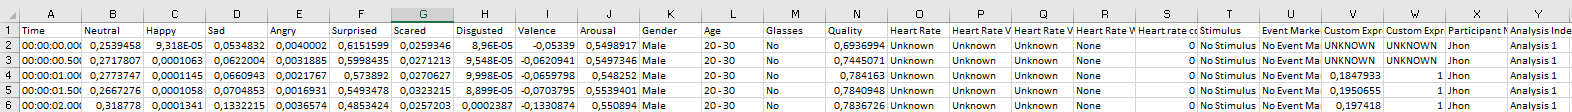

In [ ]:
#conexión a la cuenta de drive a la raiz de archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones que servirán para los siguientes análisis

In [ ]:
def extract_all_stimulus_times(df):
    stimulus_col = 'Stimulus'
    time_col = 'Time'

    # Obtener los valores únicos de los estímulos, excluyendo "No Stimulus"
    unique_stimulus = df[stimulus_col].unique()
    unique_stimulus = [valor for valor in unique_stimulus if valor != "No Stimulus"]

    # Inicializar un diccionario para almacenar los tiempos por estímulo
    stimulus_dict = {stimulus: [] for stimulus in unique_stimulus}

    current_stimulus = None  # Para rastrear el estímulo actual

    for index, row in df.iterrows():
        if len(unique_stimulus) > 0:
            new_stimulus = row[stimulus_col]

            # Si el estímulo no es "No Stimulus", agregamos el tiempo al estímulo correspondiente
            if new_stimulus != 'No Stimulus':
                # Si es un nuevo estímulo, actualizamos el estímulo actual
                if new_stimulus != current_stimulus:
                    current_stimulus = new_stimulus
                # Añadimos el tiempo al estímulo actual en el diccionario
                stimulus_dict[current_stimulus].append(row[time_col])

            # Si vuelve a "No Stimulus", reiniciamos el estímulo actual
            else:
                if current_stimulus is not None and len(stimulus_dict[current_stimulus]) > 0:
                    unique_stimulus = [valor for valor in unique_stimulus if valor != current_stimulus]

                current_stimulus = None
        else:
            break
    return stimulus_dict

def imputar_valores_con_media(df, tiempos, columnas_a_reemplazar):
    """
    Reemplaza los valores de texto por la media de los valores numéricos de las columnas seleccionadas.
    También devuelve un reporte con el número de imputaciones realizadas por columna.

    Parameters:
    df (pandas.DataFrame): El DataFrame que contiene los datos originales.
    tiempos (list): Lista de tiempos para los que se realizarán las imputaciones.
    columnas_a_reemplazar (list): Lista de columnas en las que se realizará la imputación.

    Returns:
    tuple: DataFrame con los valores imputados y un diccionario con el reporte de imputaciones por columna.
    """

    imputaciones_por_columna = {col: 0 for col in columnas_a_reemplazar}  # Inicializamos el conteo de imputaciones

    for tiempo in tiempos:
        # Filtrar el DataFrame para obtener las filas correspondientes a ese tiempo
        filas_con_tiempo = df[df['Time'] == tiempo]

        # Iterar sobre las columnas en las que queremos hacer imputación
        for col in columnas_a_reemplazar:
            # Filtrar solo los valores numéricos para la columna en esas filas
            valores_numericos = pd.to_numeric(filas_con_tiempo[col], errors='coerce')

            # Calcular la media de los valores numéricos
            media_valores = valores_numericos.mean()

            # Contamos cuántas filas tienen valores no numéricos (texto)
            num_imputaciones = filas_con_tiempo[col].apply(lambda x: isinstance(x, str)).sum()

            # Actualizamos el reporte de imputaciones
            imputaciones_por_columna[col] += num_imputaciones

            # Reemplazar los valores no numéricos con la media calculada
            df.loc[(df['Time'] == tiempo) & (df[col].apply(lambda x: isinstance(x, str))), col] = media_valores

    return df, imputaciones_por_columna

def filtrar_por_tiempos(df, tiempos_dict):
    """
    Filtra el DataFrame para que solo contenga filas con tiempos presentes en los valores del diccionario proporcionado.

    Parameters:
    df (pandas.DataFrame): El DataFrame original.
    tiempos_dict (dict): Diccionario donde las claves son nombres de estímulos y los valores son listas de tiempos.

    Returns:
    pandas.DataFrame: DataFrame filtrado que solo contiene filas con los tiempos especificados.
    """
    # Unir todas las listas de tiempos de los estímulos en una sola lista
    tiempos_filtrar = [tiempo for lista_tiempos in tiempos_dict.values() for tiempo in lista_tiempos]

    # Filtrar el DataFrame para conservar solo las filas cuyos tiempos estén en la lista de tiempos_filtrar
    df_filtrado = df[df['Time'].isin(tiempos_filtrar)]

    return df_filtrado

def plot_emotions(df_filtered, selected_columns):
    """
    Grafica solo las emociones seleccionadas de acuerdo con los estímulos.

    Parameters:
    - selected_columns: Lista de nombres de columnas que deseas graficar.
    """
    # Agrupar por estímulo y calcular la media de las emociones seleccionadas
    df_grouped_all = df_filtered.groupby('Stimulus')[selected_columns].mean()

    # Crear gráfico de barras para las emociones seleccionadas
    df_grouped_all.T.plot(kind='bar', figsize=(10, 6))

    # Configuraciones del gráfico
    plt.title('Promedio de Emociones por Estímulo (Emociones Seleccionadas)')
    plt.ylabel('Valor Promedio')
    plt.xlabel('Emociones')
    plt.legend(title='Stimulus', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



# Definir la función
def plot_expression_over_time(df, specific_times, column_names, stimulus_title="Stimulus", combine_graphs=True):
    """
    Función para graficar la media de una o más columnas (emociones, valence, arousal, etc.) en función del tiempo.

    Parámetros:
    - df: El DataFrame original.
    - specific_times: Una lista de tiempos específicos para filtrar el DataFrame.
    - column_names: Una lista de nombres de columnas que se van a graficar (pueden ser emociones, custom expressions, etc.).
    - stimulus_title: Título del estímulo (por defecto "Stimulus").
    - combine_graphs: Booleano para decidir si se grafican todas las columnas en una sola gráfica o en gráficos separados.
    """
    # Filtrar el DataFrame para incluir solo las filas con los tiempos específicos
    filtered_df = df[df['Time'].isin(specific_times)]

    # Si los gráficos van a combinarse en una sola gráfica
    if combine_graphs:
        plt.figure(figsize=(12, 6))  # Ajustar el tamaño del gráfico combinado

        # Iterar sobre cada columna y graficar en la misma figura
        for column in column_names:
            pivot_table = filtered_df.pivot_table(index=pd.RangeIndex(start=1, stop=len(filtered_df)+1),
                                                  columns='Time', values=column, aggfunc='first')

            # Calcular la media por tiempo
            means = [pivot_table[s_times].dropna().mean() for s_times in specific_times]

            # Graficar cada columna en la misma gráfica
            plt.plot(specific_times, means, marker='o', linestyle='-', label=column)

        # Añadir título, etiquetas y cuadrícula
        plt.title(f'{stimulus_title}: Expressions Over Time (Combined)')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Si los gráficos van a mostrarse por separado
    else:
        # Crear una figura con múltiples gráficos, uno para cada columna
        plt.figure(figsize=(12, 6 * len(column_names)))  # Ajustar el tamaño del gráfico basado en el número de columnas

        # Iterar sobre cada columna y crear gráficos separados
        for idx, column in enumerate(column_names):
            pivot_table = filtered_df.pivot_table(index=pd.RangeIndex(start=1, stop=len(filtered_df)+1),
                                                  columns='Time', values=column, aggfunc='first')

            # Calcular la media por tiempo
            means = [pivot_table[s_times].dropna().mean() for s_times in specific_times]

            # Crear el gráfico de líneas para cada columna
            plt.subplot(len(column_names), 1, idx + 1)
            plt.plot(specific_times, means, marker='o', linestyle='-', label=column)

            # Añadir título, etiquetas y cuadrícula
            plt.title(f'{column} Over Time - {stimulus_title}')
            plt.xlabel('Time')
            plt.ylabel(column)
            plt.xticks(rotation=45)
            plt.grid(True)

        # Ajustar el espaciado entre los subgráficos
        plt.tight_layout()
        plt.show()

# Función para crear gráficos de densidad para un estímulo específico
def plot_heatmap_for_valence_arousal(valence_data, arousal_data, stimulus_label):
    # Crear un gráfico de dispersión con una estimación de densidad
    plt.figure(figsize=(10, 8))

    # Crear el gráfico de densidad conjunto (jointplot) entre Valence y Arousal
    sns.jointplot(
        x=valence_data,
        y=arousal_data,
        kind="kde",        # Tipo de gráfico: densidad estimada
        fill=True,         # Relleno bajo las curvas de densidad
        cmap="coolwarm"    # Colores del mapa de calor
    )

    # Añadir un título al gráfico
    plt.suptitle(f'Representación Circumplex de Valence y Arousal - {stimulus_label}', y=1.02)

    # Añadir líneas en el centro de los ejes
    plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Línea horizontal en el eje Y
    plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Línea vertical en el eje X

    # Ajustar límites de los ejes
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    # Mostrar el gráfico
    plt.show()

def extract_column_averages(df, specific_times_list, column_name, stimulus_names):
    """
    Extrae los valores de una columna dada para tiempos específicos y calcula los promedios.

    Parameters:
        df (pandas.DataFrame): El DataFrame que contiene los datos.
        specific_times_list (list): Una lista de listas con los tiempos específicos por cada estímulo.
        column_name (str): El nombre de la columna a extraer (ej. 'Valence', 'Arousal').
        stimulus_names (list): Los nombres de los estímulos para utilizar como claves del diccionario.

    Returns:
        dict: Un diccionario donde las claves son los nombres de los estímulos y los valores son listas con los promedios.
        int: La longitud de la lista más corta de promedios.
    """
    averages_per_stimulus = {}

    for idx, specific_times in enumerate(specific_times_list):
        # Filtrar el DataFrame para incluir solo las filas con los tiempos específicos del estímulo actual
        filtered_df = df[df['Time'].isin(specific_times)]

        # Extraer los valores de la columna especificada y calcular los promedios para cada tiempo
        averages = [filtered_df[filtered_df['Time'] == time][column_name].mean() for time in specific_times]

        # Asignar los promedios al diccionario utilizando el nombre del estímulo
        averages_per_stimulus[stimulus_names[idx]] = averages

    # Encontrar la longitud mínima de todas las listas de promedios
    min_length = min([len(avg_list) for avg_list in averages_per_stimulus.values()])

    return averages_per_stimulus, min_length

def plot_averages(averages_dict, title, ylabel):
    """
    Grafica los promedios de diferentes estímulos, ajustados al tamaño de la lista más corta.

    Parameters:
        averages_dict (dict): Diccionario con los promedios de cada estímulo.
        title (str): El título del gráfico.
        ylabel (str): La etiqueta del eje Y (ej. 'Valence', 'Arousal', etc.).
    """
    # Encontrar el tamaño mínimo entre todas las listas en el diccionario
    min_length = min(len(avg_list) for avg_list in averages_dict.values())

    # Crear un rango para el eje X basado en el número de elementos (min_length)
    elem = list(range(min_length))

    # Colores y estilos dinámicos para cada estímulo
    colors = plt.cm.get_cmap('tab10', len(averages_dict))  # Obtener un colormap que genere suficientes colores

    # Crear una figura
    plt.figure(figsize=(12, 6))

    # Iterar sobre cada estímulo y sus promedios
    for idx, (stimulus, avg_list) in enumerate(averages_dict.items()):
        # Graficar solo los primeros min_length elementos de cada lista
        plt.plot(elem, avg_list[:min_length], marker='o', linestyle='-', color=colors(idx), label=stimulus)

    # Añadir título y etiquetas
    plt.title(title)
    plt.xlabel('Número de registros')
    plt.ylabel(ylabel)

    # Rotar las etiquetas del eje X para mejorar la visualización
    plt.xticks(rotation=45)

    # Añadir una cuadrícula
    plt.grid(True)

    # Añadir leyenda
    plt.legend()

    # Mostrar el gráfico
    plt.show()

# **DATOS DE ENTRADA**

In [ ]:
# Leer el documento
df = pd.read_excel("/content/Gaseosas_20250404_111048_detailed.xlsx")
df.head(5)

Time   Neutral     Happy       Sad     Angry Surprised    Scared  \
0  00:00:00.000  0.353978   0.01923  0.379087  0.003775  0.003425  0.000072   
1  00:00:01.000  0.485121   0.00943  0.370579  0.011917  0.006919  0.000213   
2  00:00:02.000  0.708761  0.001693  0.264056  0.014849  0.028735  0.000305   
3  00:00:03.000  0.512678  0.017329  0.082922  0.008334  0.068597  0.001552   
4  00:00:04.000   0.27791   0.00365  0.035228  0.011775  0.563248  0.009219   

  Disgusted   Valence   Arousal     Stimulus     Event Marker  \
0  0.205999 -0.359857  0.212523  No Stimulus  No Event Marker   
1  0.100255 -0.361149  0.357586  No Stimulus  No Event Marker   
2  0.018252 -0.262362  0.479734  No Stimulus  No Event Marker   
3  0.218027 -0.200697  0.396426  No Stimulus  No Event Marker   
4  0.037722 -0.034072  0.509084  No Stimulus  No Event Marker   

  Custom Expression - Interest Custom Expression - Attention Participant Name  \
0                      UNKNOWN                       UNKNOWN           Hellen   
1                            0                      0.991221           Hellen   
2                            0                             1           Hellen   
3                            0                      0.917443           Hellen   
4                            0                      0.952038           Hellen   

  Analysis Index  
0     Analysis 1  
1     Analysis 1  
2     Analysis 1  
3     Analysis 1  
4     Analysis 1

In [ ]:
# Lista de emociones o columnas que deseas analizar
emotions = ['Happy', 'Sad', 'Angry', 'Surprised', 'Scared', 'Disgusted'] # []
custom_expresion = ['Custom Expression - Attention', 'Custom Expression - Interest'] # []
val_aro = ['Valence', 'Arousal'] #[]

## Extraer el tiempo por cada estímulo y realizar imputaciones en caso de ser necesario (por valores no númericos)

In [ ]:
# Extraer los tiempos por cada estímulo
specific_times_stimulus = extract_all_stimulus_times(df)
for specific_times in specific_times_stimulus:
    print(f"{specific_times}:{specific_times_stimulus[specific_times]}")

coca cola:['00:00:05.000', '00:00:06.000', '00:00:07.000', '00:00:08.000', '00:00:09.000', '00:00:10.000', '00:00:11.000', '00:00:12.000', '00:00:13.000', '00:00:14.000', '00:00:15.000', '00:00:16.000', '00:00:17.000', '00:00:18.000', '00:00:19.000', '00:00:20.000', '00:00:21.000', '00:00:22.000', '00:00:23.000', '00:00:24.000', '00:00:25.000', '00:00:26.000', '00:00:27.000', '00:00:28.000', '00:00:29.000', '00:00:30.000', '00:00:31.000', '00:00:32.000', '00:00:33.000', '00:00:34.000', '00:00:35.000', '00:00:36.000', '00:00:37.000', '00:00:38.000', '00:00:39.000', '00:00:40.000', '00:00:41.000', '00:00:42.000', '00:00:43.000', '00:00:44.000', '00:00:45.000', '00:00:46.000', '00:00:47.000', '00:00:48.000', '00:00:49.000', '00:00:50.000', '00:00:51.000', '00:00:52.000', '00:00:53.000', '00:00:54.000', '00:00:55.000', '00:00:56.000', '00:00:57.000', '00:00:58.000', '00:00:59.000', '00:01:00.000', '00:01:01.000', '00:01:02.000', '00:01:03.000', '00:01:04.000']
sprite:['00:01:09.000', '00:0

In [ ]:
emotions = ['Neutral', 'Happy', 'Sad', 'Angry', 'Surprised', 'Scared', 'Disgusted']
val_aro = ['Valence', 'Arousal']
custom_expresion = ['Custom Expression - Interest', 'Custom Expression - Attention']

# Determinación de las columnas con las que se va a trabajar, con base en las columnas especificadas
columnas = emotions + val_aro + custom_expresion
print(f"columnas: {columnas}")

# ... (rest of your code) ...

columnas: ['Neutral', 'Happy', 'Sad', 'Angry', 'Surprised', 'Scared', 'Disgusted', 'Valence', 'Arousal', 'Custom Expression - Interest', 'Custom Expression - Attention']


In [ ]:
# Llamar a la función para realizar la imputación con media
for specific_times in specific_times_stimulus:
    print(f"{specific_times}:{specific_times_stimulus[specific_times]}")
    df, imputaciones_por_columna = imputar_valores_con_media(df, specific_times_stimulus[specific_times], columnas)
    print(f"Imputaciones por columna: {imputaciones_por_columna}")

coca cola:['00:00:05.000', '00:00:06.000', '00:00:07.000', '00:00:08.000', '00:00:09.000', '00:00:10.000', '00:00:11.000', '00:00:12.000', '00:00:13.000', '00:00:14.000', '00:00:15.000', '00:00:16.000', '00:00:17.000', '00:00:18.000', '00:00:19.000', '00:00:20.000', '00:00:21.000', '00:00:22.000', '00:00:23.000', '00:00:24.000', '00:00:25.000', '00:00:26.000', '00:00:27.000', '00:00:28.000', '00:00:29.000', '00:00:30.000', '00:00:31.000', '00:00:32.000', '00:00:33.000', '00:00:34.000', '00:00:35.000', '00:00:36.000', '00:00:37.000', '00:00:38.000', '00:00:39.000', '00:00:40.000', '00:00:41.000', '00:00:42.000', '00:00:43.000', '00:00:44.000', '00:00:45.000', '00:00:46.000', '00:00:47.000', '00:00:48.000', '00:00:49.000', '00:00:50.000', '00:00:51.000', '00:00:52.000', '00:00:53.000', '00:00:54.000', '00:00:55.000', '00:00:56.000', '00:00:57.000', '00:00:58.000', '00:00:59.000', '00:01:00.000', '00:01:01.000', '00:01:02.000', '00:01:03.000', '00:01:04.000']
Imputaciones por columna: {'N

In [ ]:
# Eliminar a todas las filas que no estén dentro de los tiempos
df_filtered = filtrar_por_tiempos(df, specific_times_stimulus)
df_filtered.head()

Time   Neutral     Happy       Sad     Angry Surprised    Scared  \
5  00:00:05.000  0.633649  0.002087  0.187119  0.023298  0.314298  0.002966   
6  00:00:06.000   0.58014  0.014762  0.107971  0.013145  0.502612  0.002595   
7  00:00:07.000  0.525406  0.022309  0.037413   0.00507  0.616103  0.002931   
8  00:00:08.000   0.70147  0.049806  0.024029  0.009629  0.381816  0.001787   
9  00:00:09.000  0.671206  0.057653  0.026322  0.013534  0.393879  0.001908   

  Disgusted   Valence   Arousal   Stimulus     Event Marker  \
5  0.002631 -0.185032  0.560107  coca cola  No Event Marker   
6  0.000835  -0.09321  0.508339  coca cola  No Event Marker   
7  0.001134 -0.015104  0.519865  coca cola  No Event Marker   
8  0.001439  0.025777  0.505243  coca cola  No Event Marker   
9  0.001795  0.031332   0.47002  coca cola  No Event Marker   

  Custom Expression - Interest Custom Expression - Attention Participant Name  \
5                            0                      0.883401           Hellen   
6                            0                      0.908754           Hellen   
7                            0                      0.967574           Hellen   
8                            0                      0.993328           Hellen   
9                            0                      0.997212           Hellen   

  Analysis Index  
5     Analysis 1  
6     Analysis 1  
7     Analysis 1  
8     Analysis 1  
9     Analysis 1

In [ ]:
# Display descriptive statistics
df_filtered.describe()

Time      Neutral        Happy          Sad      Angry  \
count           9576  9576.000000  9576.000000  9576.000000  9576.0000   
unique           168  9556.000000  9575.000000  9571.000000  9574.0000   
top     00:00:05.000     0.987138     0.002503     0.034662     0.0027   
freq              57     2.000000     2.000000     2.000000     2.0000   

          Surprised      Scared    Disgusted      Valence    Arousal Stimulus  \
count   9576.000000  9576.00000  9576.000000  9576.000000  9576.0000     9576   
unique  9574.000000  9573.00000  9576.000000  9568.000000  8634.0000        4   
top        0.012357     0.00342     0.002054    -0.028544     0.2475    fanta   
freq       2.000000     2.00000     1.000000     2.000000   481.0000     3390   

           Event Marker  Custom Expression - Interest  \
count              9576                          9576   
unique                1                          1838   
top     No Event Marker                             0   
freq               9576                          7739   

        Custom Expression - Attention Participant Name Analysis Index  
count                            9576             9576           9576  
unique                           3909               51              1  
top                                 1            Kevin     Analysis 1  
freq                             5660              672           9576

#**Estadísticos generales**

In [ ]:
df_filtered = df_filtered[df_filtered["Stimulus"] != "No Stimulus"]
# Agrupar por 'Stimulus' y calcular la media de las respuestas emocionales
df_grouped = df_filtered.groupby('Stimulus')[columnas].mean()

# Mostrar los resultados
df_grouped

Neutral     Happy       Sad     Angry Surprised    Scared  \
Stimulus                                                                
coca cola  0.804067  0.029136  0.092034  0.042146  0.021552  0.008793   
fanta      0.769624  0.014167  0.121335   0.05575  0.016958  0.012296   
sprite     0.756931  0.068475  0.081824  0.039362  0.023905  0.009775   

          Disgusted   Valence   Arousal Custom Expression - Interest  \
Stimulus                                                               
coca cola  0.006503 -0.087485  0.279318                     0.013848   
fanta      0.006538 -0.142426  0.265572                     0.015567   
sprite     0.009656 -0.040449  0.281993                     0.012289   

          Custom Expression - Attention  
Stimulus                                 
coca cola                      0.978002  
fanta                          0.974098  
sprite                         0.978132

In [ ]:
# ----------------------------------------------------
# Desviación estándar de columnas por estímulo
# ----------------------------------------------------
df_grouped_std = df_filtered.groupby('Stimulus')[columnas].std()
df_grouped_std

Neutral     Happy       Sad     Angry  Surprised    Scared  \
Stimulus                                                                 
coca cola  0.208037  0.121794  0.113383  0.074402   0.052947  0.022433   
fanta      0.232719  0.074957  0.163616  0.120326   0.036594  0.035191   
sprite     0.246035  0.173516  0.120265  0.091006   0.061037  0.026888   

           Disgusted   Valence   Arousal  Custom Expression - Interest  \
Stimulus                                                                 
coca cola   0.019801  0.170314  0.048648                      0.037591   
fanta       0.019673  0.192127  0.037005                      0.042878   
sprite      0.030901  0.231399  0.053835                      0.035458   

           Custom Expression - Attention  
Stimulus                                  
coca cola                       0.044089  
fanta                           0.047903  
sprite                          0.041475

In [ ]:
# ----------------------------------------------------
# Mediana de columnas por estímulo
# ----------------------------------------------------
df_grouped_median = df_filtered.groupby('Stimulus')[columnas].median()
df_grouped_median

Neutral     Happy       Sad     Angry Surprised    Scared  \
Stimulus                                                                
coca cola  0.894837  0.000814  0.047736  0.012466  0.006237  0.001368   
fanta      0.871803  0.000438  0.056075  0.014324  0.004731   0.00104   
sprite     0.866539  0.002684  0.034925  0.010694  0.005681  0.001061   

          Disgusted   Valence   Arousal Custom Expression - Interest  \
Stimulus                                                               
coca cola  0.000937 -0.063994  0.261737                          0.0   
fanta      0.001163 -0.088665  0.255149                          0.0   
sprite     0.000969 -0.043002  0.262298                          0.0   

          Custom Expression - Attention  
Stimulus                                 
coca cola                           1.0  
fanta                               1.0  
sprite                              1.0

In [ ]:
# ----------------------------------------------------
# Mínimo valor en columnas por estímulo
# ----------------------------------------------------
df_grouped_min = df_filtered.groupby('Stimulus')[columnas].min()
df_grouped_min

Neutral     Happy       Sad     Angry Surprised    Scared  \
Stimulus                                                                
coca cola  0.037445  0.000001  0.000061  0.000009  0.000005  0.000001   
fanta      0.024082       0.0  0.000216  0.000024   0.00001  0.000001   
sprite     0.007601       0.0  0.000025   0.00001  0.000006       0.0   

          Disgusted   Valence   Arousal Custom Expression - Interest  \
Stimulus                                                               
coca cola  0.000001 -0.820644   0.07866                            0   
fanta      0.000004 -0.873391  0.069786                            0   
sprite          0.0 -0.898977   0.14103                            0   

          Custom Expression - Attention  
Stimulus                                 
coca cola                      0.629365  
fanta                          0.627566  
sprite                         0.629083

In [ ]:
# ----------------------------------------------------
# Máximo valor en columnas por estímulo
# ----------------------------------------------------
df_grouped_max = df_filtered.groupby('Stimulus')[columnas].max()
df_grouped_max

Neutral     Happy       Sad     Angry Surprised    Scared  \
Stimulus                                                                
coca cola   0.99797  0.925505  0.820654  0.710341  0.686018   0.19764   
fanta      0.998639  0.951496  0.900739  0.873392  0.568645  0.257913   
sprite     0.998693  0.985961  0.772989  0.898979  0.607599  0.204842   

          Disgusted   Valence   Arousal Custom Expression - Interest  \
Stimulus                                                               
coca cola  0.322316  0.878847   0.66353                     0.251874   
fanta       0.44313  0.941184  0.682885                     0.275945   
sprite     0.588923  0.985716  0.768333                     0.260976   

          Custom Expression - Attention  
Stimulus                                 
coca cola                             1  
fanta                                 1  
sprite                                1

#**Emociones básicas**

## Diagramas de barras de emociones básicas

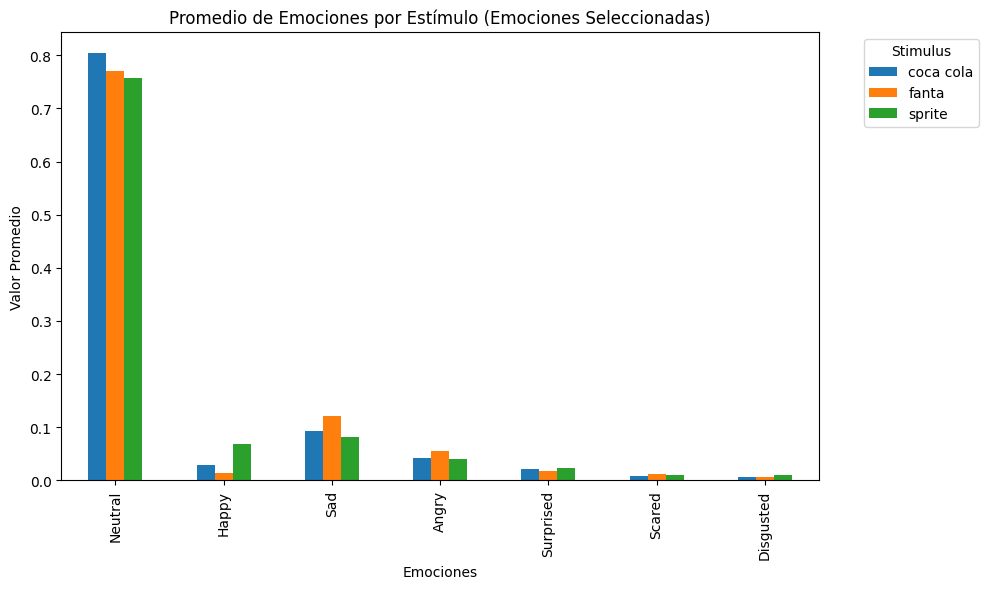

In [ ]:
# Ejemplo de llamada a la función con las columnas que deseas graficar
plot_emotions(df_filtered, emotions)

## Gráfica de emociones por estímulo

coca cola:['00:00:05.000', '00:00:06.000', '00:00:07.000', '00:00:08.000', '00:00:09.000', '00:00:10.000', '00:00:11.000', '00:00:12.000', '00:00:13.000', '00:00:14.000', '00:00:15.000', '00:00:16.000', '00:00:17.000', '00:00:18.000', '00:00:19.000', '00:00:20.000', '00:00:21.000', '00:00:22.000', '00:00:23.000', '00:00:24.000', '00:00:25.000', '00:00:26.000', '00:00:27.000', '00:00:28.000', '00:00:29.000', '00:00:30.000', '00:00:31.000', '00:00:32.000', '00:00:33.000', '00:00:34.000', '00:00:35.000', '00:00:36.000', '00:00:37.000', '00:00:38.000', '00:00:39.000', '00:00:40.000', '00:00:41.000', '00:00:42.000', '00:00:43.000', '00:00:44.000', '00:00:45.000', '00:00:46.000', '00:00:47.000', '00:00:48.000', '00:00:49.000', '00:00:50.000', '00:00:51.000', '00:00:52.000', '00:00:53.000', '00:00:54.000', '00:00:55.000', '00:00:56.000', '00:00:57.000', '00:00:58.000', '00:00:59.000', '00:01:00.000', '00:01:01.000', '00:01:02.000', '00:01:03.000', '00:01:04.000']


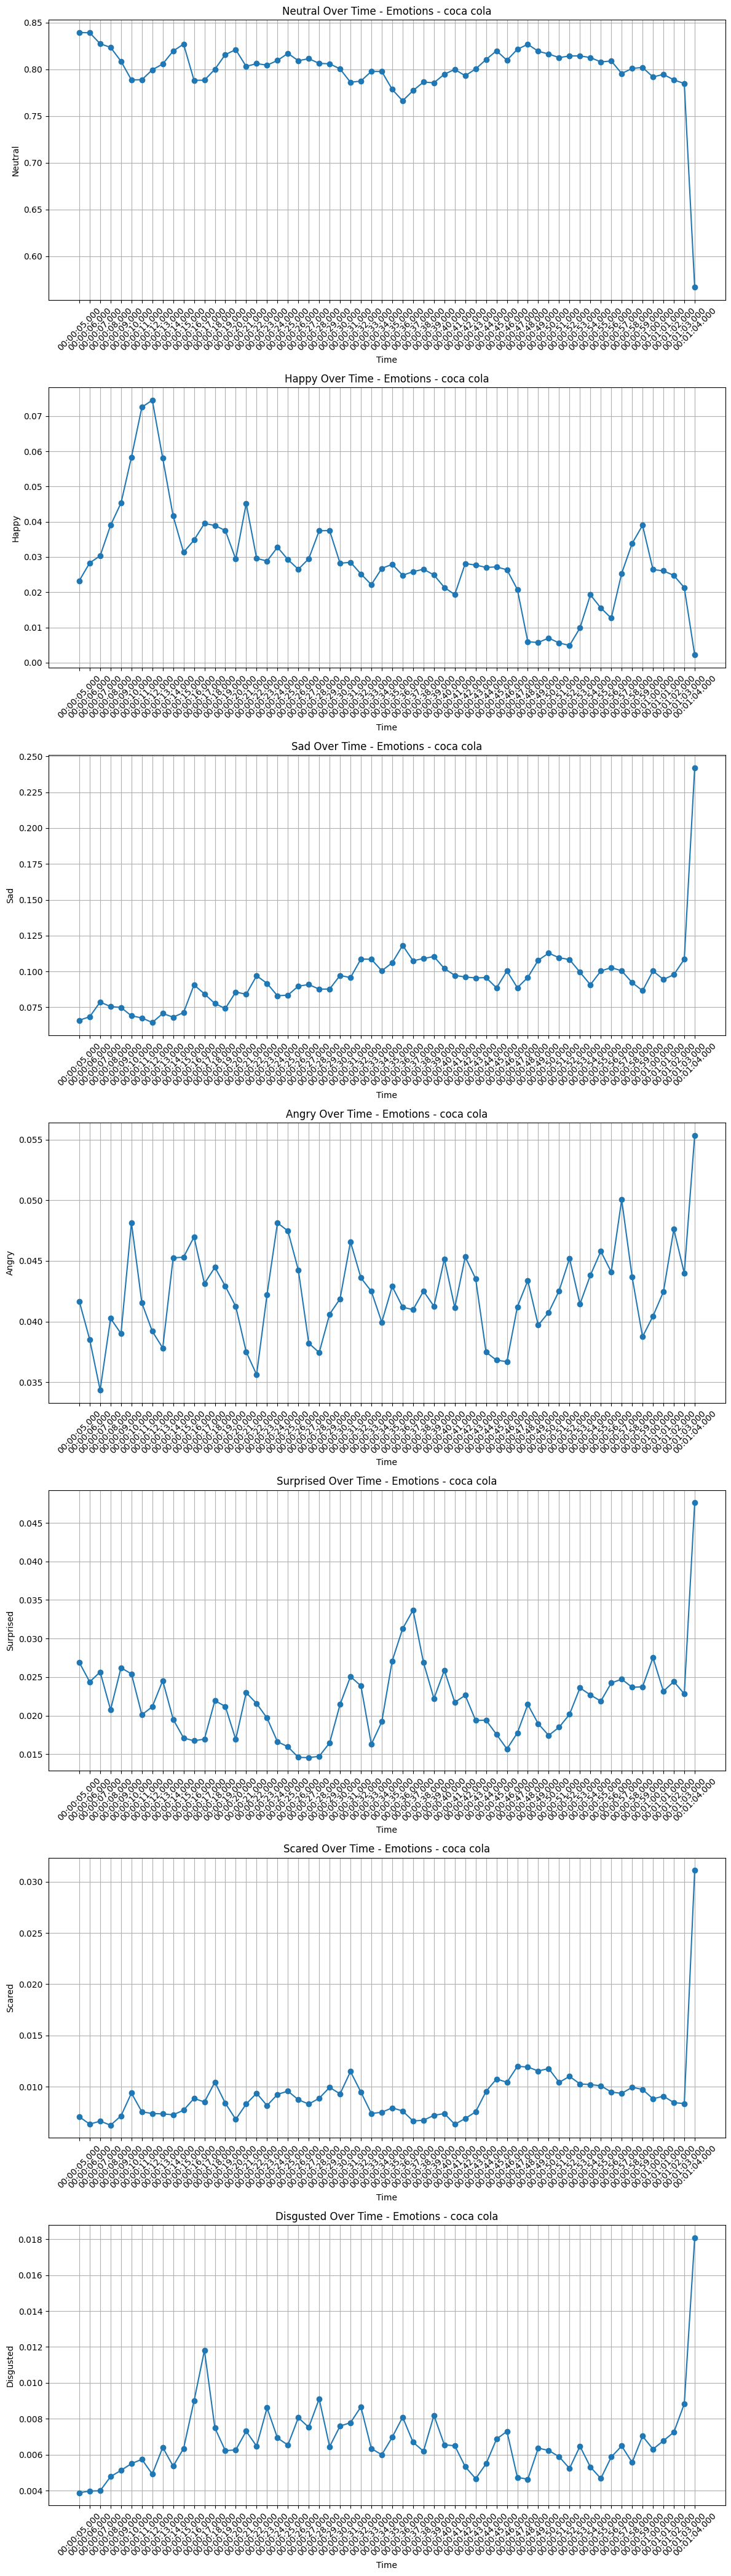

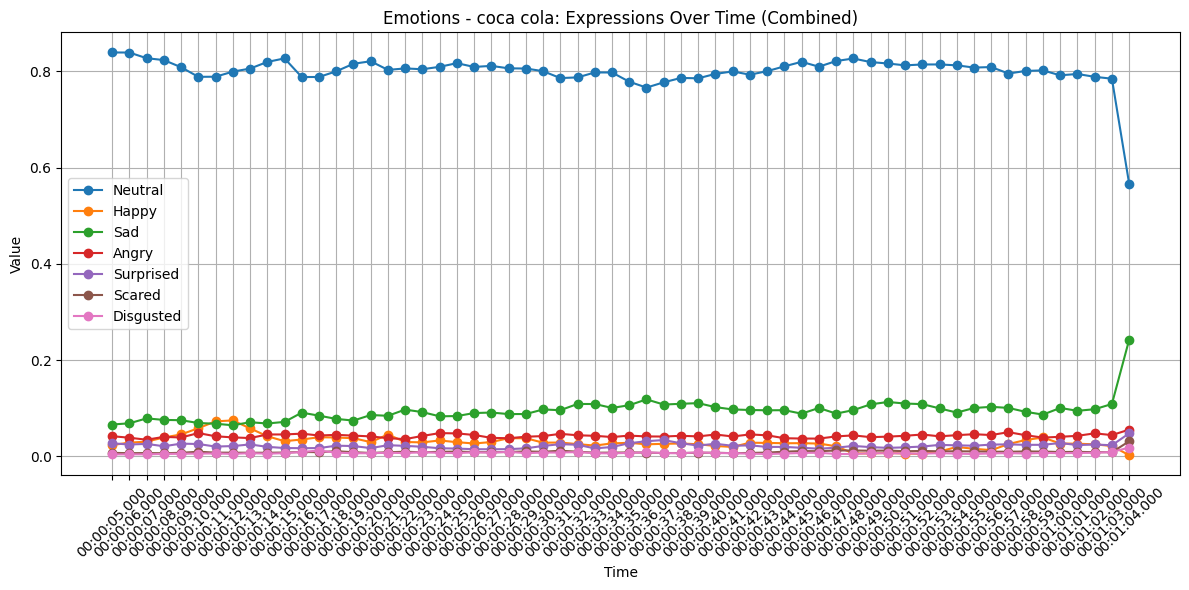

sprite:['00:01:09.000', '00:01:10.000', '00:01:11.000', '00:01:12.000', '00:01:13.000', '00:01:14.000', '00:01:15.000', '00:01:16.000', '00:01:17.000', '00:01:18.000', '00:01:19.000', '00:01:20.000', '00:01:21.000', '00:01:22.000', '00:01:23.000', '00:01:24.000', '00:01:25.000', '00:01:26.000', '00:01:27.000', '00:01:28.000', '00:01:29.000', '00:01:30.000', '00:01:31.000', '00:01:32.000', '00:01:33.000', '00:01:34.000', '00:01:35.000', '00:01:36.000', '00:01:37.000', '00:01:38.000', '00:01:39.000', '00:01:40.000', '00:01:41.000', '00:01:42.000', '00:01:43.000', '00:01:44.000', '00:01:45.000', '00:01:46.000', '00:01:47.000', '00:01:48.000', '00:01:49.000', '00:01:50.000', '00:01:51.000', '00:01:52.000', '00:01:53.000', '00:01:54.000', '00:01:55.000', '00:01:56.000']


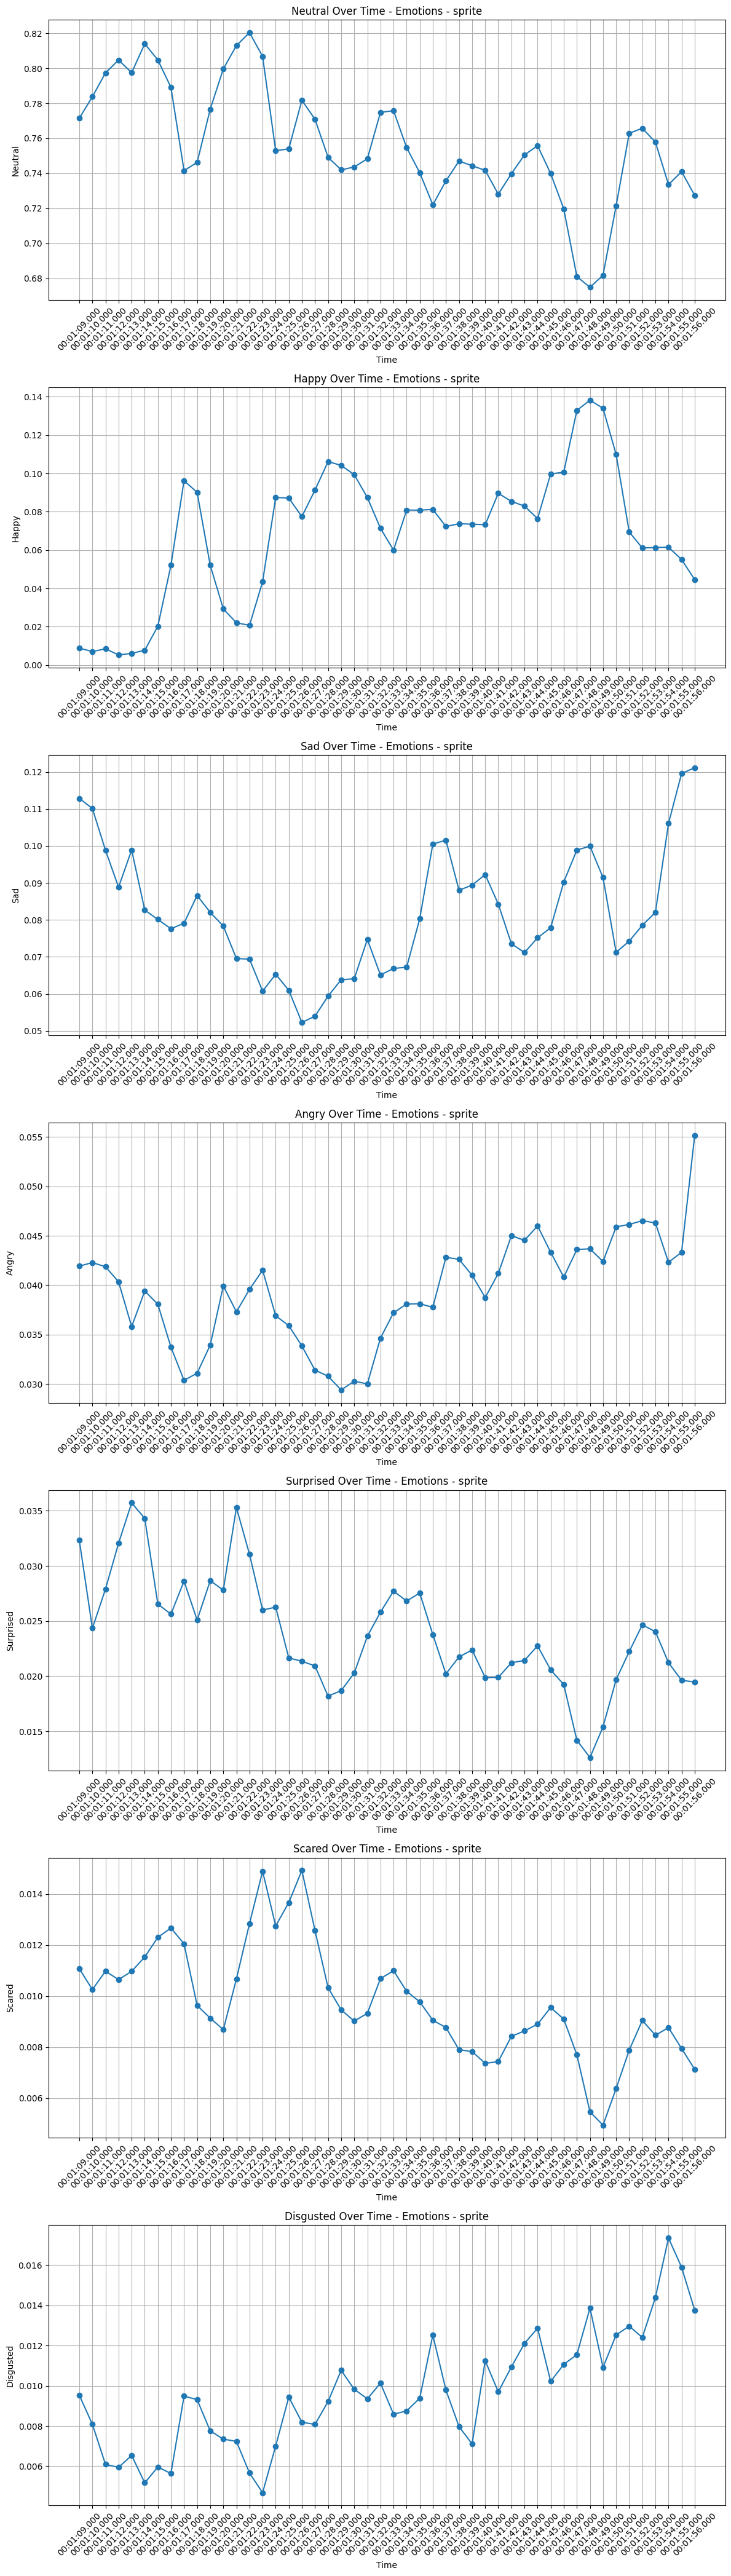

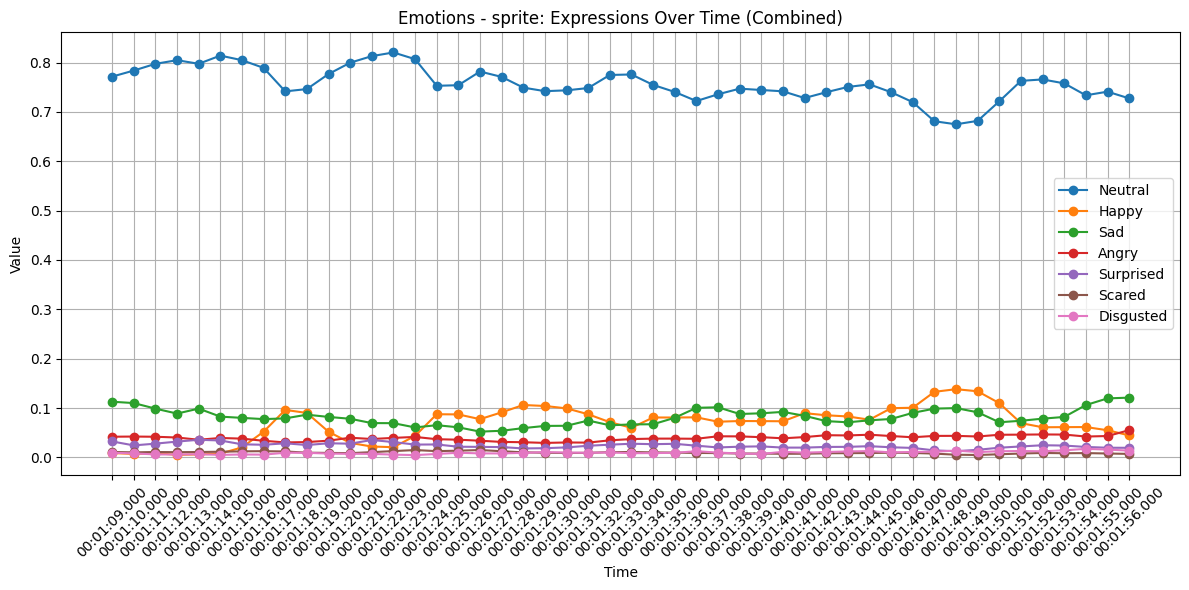

fanta:['00:02:01.000', '00:02:02.000', '00:02:03.000', '00:02:04.000', '00:02:05.000', '00:02:06.000', '00:02:07.000', '00:02:08.000', '00:02:09.000', '00:02:10.000', '00:02:11.000', '00:02:12.000', '00:02:13.000', '00:02:14.000', '00:02:15.000', '00:02:16.000', '00:02:17.000', '00:02:18.000', '00:02:19.000', '00:02:20.000', '00:02:21.000', '00:02:22.000', '00:02:23.000', '00:02:24.000', '00:02:25.000', '00:02:26.000', '00:02:27.000', '00:02:28.000', '00:02:29.000', '00:02:30.000', '00:02:31.000', '00:02:32.000', '00:02:33.000', '00:02:34.000', '00:02:35.000', '00:02:36.000', '00:02:37.000', '00:02:38.000', '00:02:39.000', '00:02:40.000', '00:02:41.000', '00:02:42.000', '00:02:43.000', '00:02:44.000', '00:02:45.000', '00:02:46.000', '00:02:47.000', '00:02:48.000', '00:02:49.000', '00:02:50.000', '00:02:51.000', '00:02:52.000', '00:02:53.000', '00:02:54.000', '00:02:55.000', '00:02:56.000', '00:02:57.000', '00:02:58.000', '00:02:59.000', '00:03:00.000']


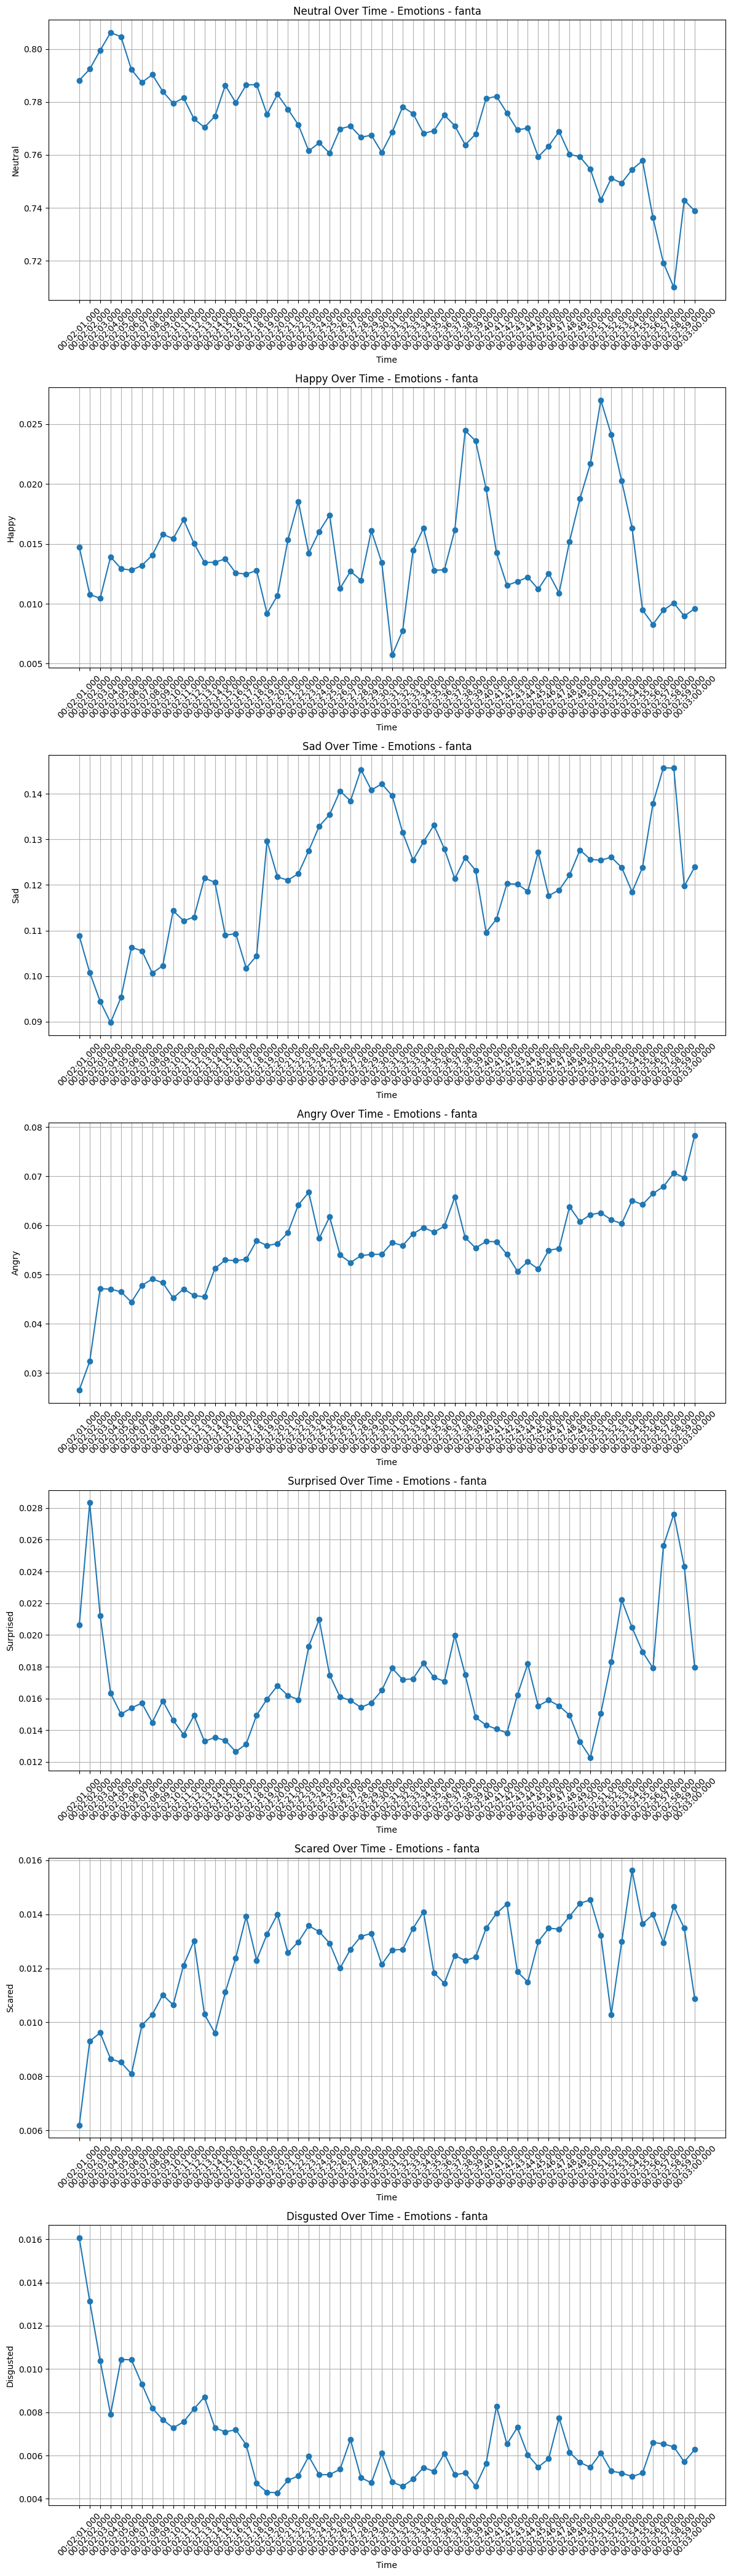

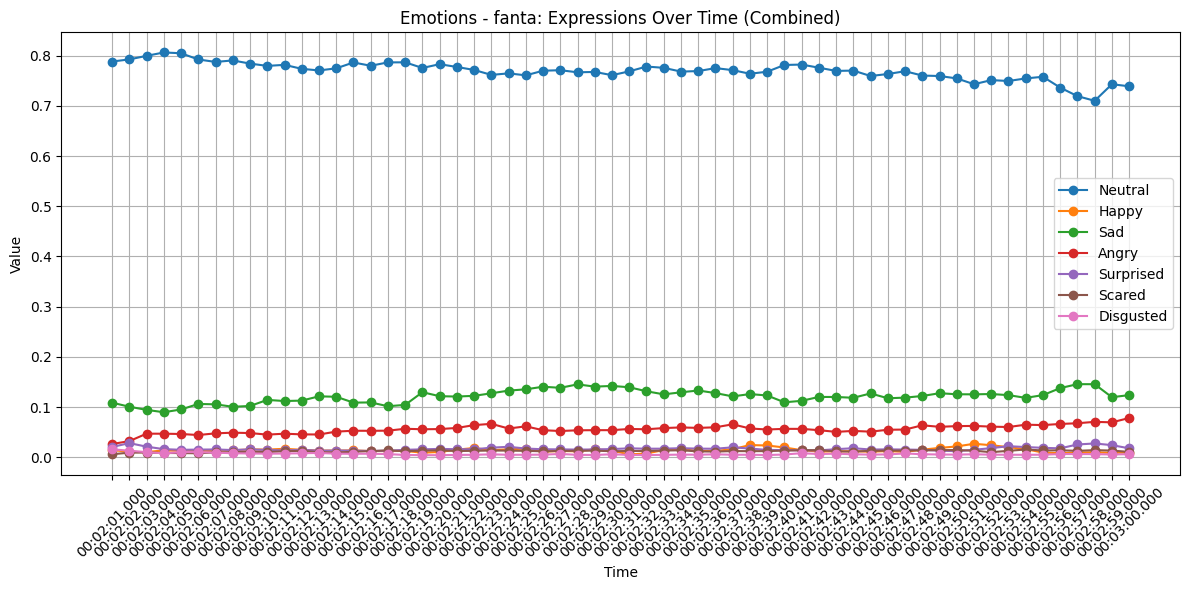

In [ ]:
# Llamar a la función para realizar la imputación con media
for specific_times in specific_times_stimulus:
    print(f"{specific_times}:{specific_times_stimulus[specific_times]}")

    # Usar la función para graficar con gráficos separados
    plot_expression_over_time(df_filtered, specific_times_stimulus[specific_times], emotions, stimulus_title=f"Emotions - {specific_times}", combine_graphs=False)

    # Usar la función para graficar con gráficos combinados en una sola gráfica
    plot_expression_over_time(df_filtered, specific_times_stimulus[specific_times], emotions, stimulus_title=f"Emotions - {specific_times}", combine_graphs=True)

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.8393276947368422), np.float64(0.8392215210526315), np.float64(0.8273989501754385), np.float64(0.8235247496491229), np.float64(0.8086614212280699), np.float64(0.7886986219642855), np.float64(0.7889066635087724), np.float64(0.7994842821052632), np.float64(0.8058117866666668), np.float64(0.8196099647368422), np.float64(0.8270202471929825), np.float64(0.7882747687719301), np.float64(0.7883838947368419), np.float64(0.8001135754385966), np.float64(0.8158411157894737), np.float64(0.8210508228070179), np.float64(0.8031112477192981), np.float64(0.806166840350877), np.float64(0.8044723228070175), np.float64(0.8094860473684208), np.float64(0.8171272403508777), np.float64(0.8092384589473683), np.float64(0.8114654838596492), np.float64(0.806339362631579), np.float64(0.8059555740350878), np.float64(0.800459345614035), np.float64(0.7861405543859649), np.float64(0.7874697333333334), np.float64(0.7978054473684213), np.float64(0.79771215964

<ipython-input-3-84ab4f82d6a8>:260: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(averages_dict))  # Obtener un colormap que genere suficientes colores


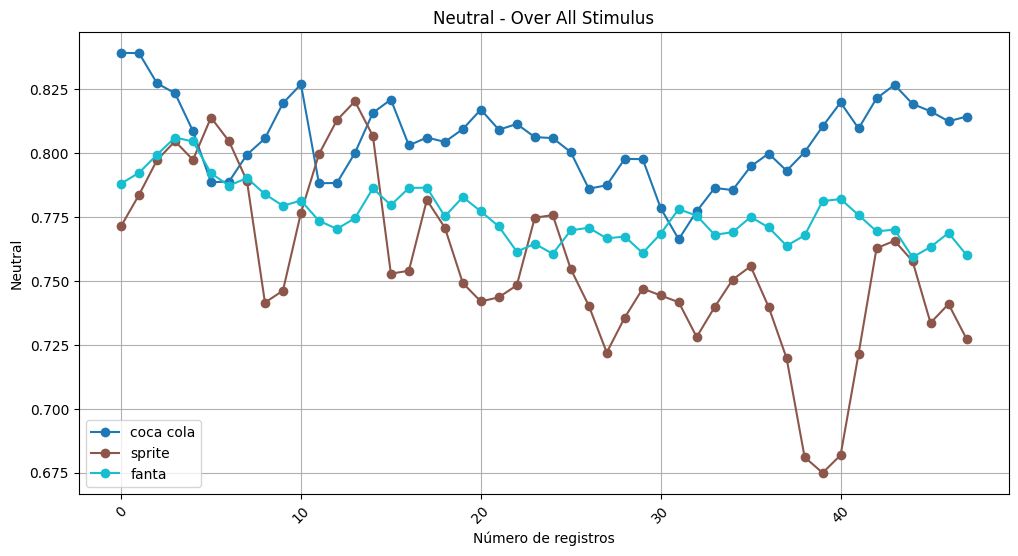

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.023274518154368422), np.float64(0.0283313145122807), np.float64(0.03032221251168421), np.float64(0.038991389634087714), np.float64(0.04532787888330527), np.float64(0.05831533514407143), np.float64(0.07251328050821051), np.float64(0.07450230134028772), np.float64(0.05800600001359649), np.float64(0.041620060988894744), np.float64(0.03132543684471929), np.float64(0.0347983010017193), np.float64(0.03951330426403509), np.float64(0.03893817659063158), np.float64(0.03751623190484211), np.float64(0.02939013222985965), np.float64(0.045182749177947366), np.float64(0.029628387611912277), np.float64(0.028829996336263167), np.float64(0.03277889767163158), np.float64(0.029264584327964912), np.float64(0.026508023995), np.float64(0.029519722692614023), np.float64(0.03743833824684212), np.float64(0.0374920223002807), np.float64(0.02821994085514035), np.float64(0.028498455187017543), np.float64(0.025189887893228076), np.float64(0.0221535270

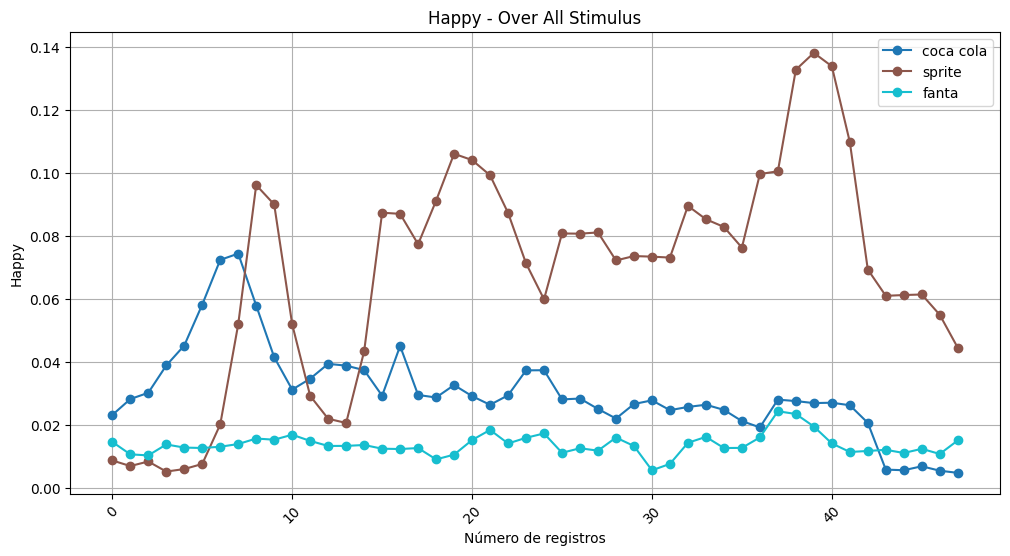

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.06596942590526317), np.float64(0.06847112657017547), np.float64(0.07867200363859647), np.float64(0.07552520495964912), np.float64(0.0749052841719298), np.float64(0.06907578188571428), np.float64(0.06760474407017543), np.float64(0.0644002549), np.float64(0.07070399639999998), np.float64(0.06811881255614036), np.float64(0.07137085142982459), np.float64(0.09064045622105264), np.float64(0.08436970673684212), np.float64(0.0776193013140351), np.float64(0.07415683389298246), np.float64(0.0856997910350877), np.float64(0.08408841963859649), np.float64(0.09700419537543858), np.float64(0.09170055056719295), np.float64(0.08302379678947369), np.float64(0.08353080865263157), np.float64(0.08978024167894737), np.float64(0.09085214884561402), np.float64(0.08767106564789474), np.float64(0.0877576672368421), np.float64(0.09723081816719299), np.float64(0.09573330330982456), np.float64(0.10868840317719299), np.float64(0.10853363138596489), np.

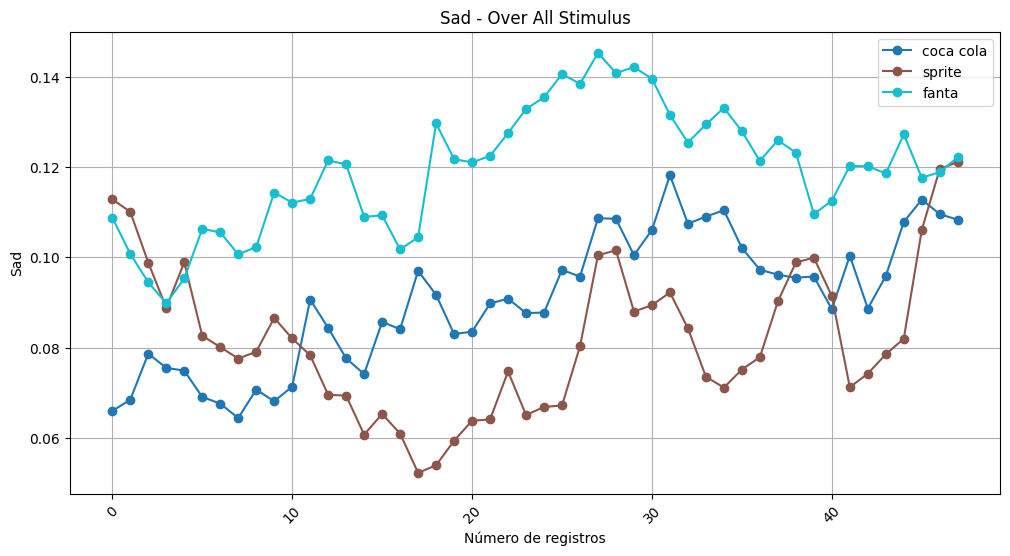

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.04167089535280702), np.float64(0.038510094249526304), np.float64(0.034347052207105266), np.float64(0.04025854124245614), np.float64(0.03900676235280701), np.float64(0.04814734119785715), np.float64(0.04153126381912279), np.float64(0.039194643261403504), np.float64(0.03781523715491229), np.float64(0.045240744445614045), np.float64(0.045308656206666645), np.float64(0.04697156803), np.float64(0.04312747217771929), np.float64(0.044468501043508774), np.float64(0.042911434205087716), np.float64(0.04124636611807019), np.float64(0.037507528380350874), np.float64(0.03562063004543859), np.float64(0.0422230697745614), np.float64(0.04813146441473685), np.float64(0.04746952339666667), np.float64(0.04424863518982455), np.float64(0.03821292182754385), np.float64(0.037440367187719294), np.float64(0.040608298547894744), np.float64(0.0418701277645614), np.float64(0.046577833506842095), np.float64(0.043603159632456125), np.float64(0.04248621

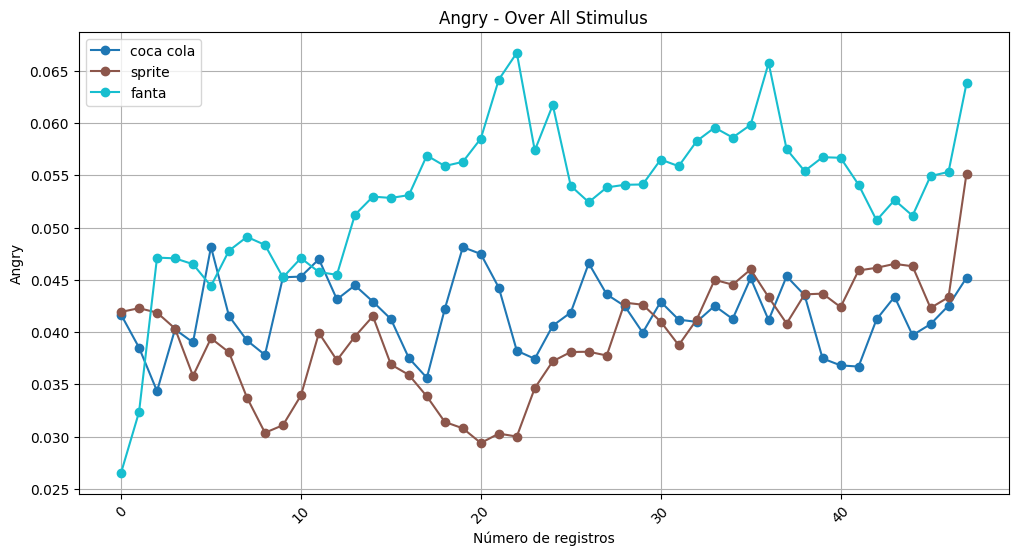

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.026911891927368415), np.float64(0.02438193397368421), np.float64(0.02567312065017544), np.float64(0.020770118941087722), np.float64(0.026212060029649122), np.float64(0.025421495071857148), np.float64(0.020127068857561402), np.float64(0.021157584000350883), np.float64(0.024555584757894742), np.float64(0.019536919913508772), np.float64(0.017113761764210526), np.float64(0.016751989717192984), np.float64(0.01697296615210526), np.float64(0.02195470757070176), np.float64(0.021204240646842103), np.float64(0.016928451499789474), np.float64(0.022996137785701757), np.float64(0.021578125540842097), np.float64(0.019702271105964907), np.float64(0.016629188145614038), np.float64(0.015978704586491227), np.float64(0.014599991638421055), np.float64(0.014565197964385964), np.float64(0.014743332725789475), np.float64(0.016476665125438595), np.float64(0.021460042293508768), np.float64(0.025075256454912275), np.float64(0.023872485972105267), n

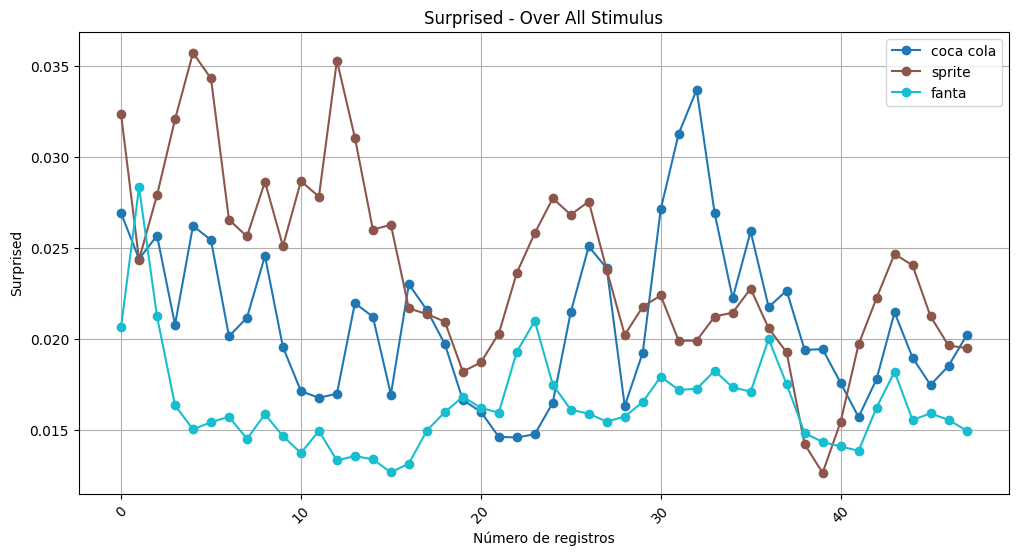

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.007079925022614034), np.float64(0.00635716407245614), np.float64(0.00665627297917544), np.float64(0.006256980562842106), np.float64(0.007166285530122807), np.float64(0.009388531729107145), np.float64(0.0075568684968421035), np.float64(0.007397561542929825), np.float64(0.00735980097768421), np.float64(0.007270537327052629), np.float64(0.007719440719087721), np.float64(0.008868382447473679), np.float64(0.008520653021210528), np.float64(0.010461612281315785), np.float64(0.008404066987228072), np.float64(0.006826916982614037), np.float64(0.008321065606035086), np.float64(0.00937699471554386), np.float64(0.00816711925117544), np.float64(0.009263465540280702), np.float64(0.009576822991877195), np.float64(0.008743761808754386), np.float64(0.008313010846315787), np.float64(0.008884445854245611), np.float64(0.009946267151315795), np.float64(0.009309444946877193), np.float64(0.011488808497894739), np.float64(0.009484575485561402), n

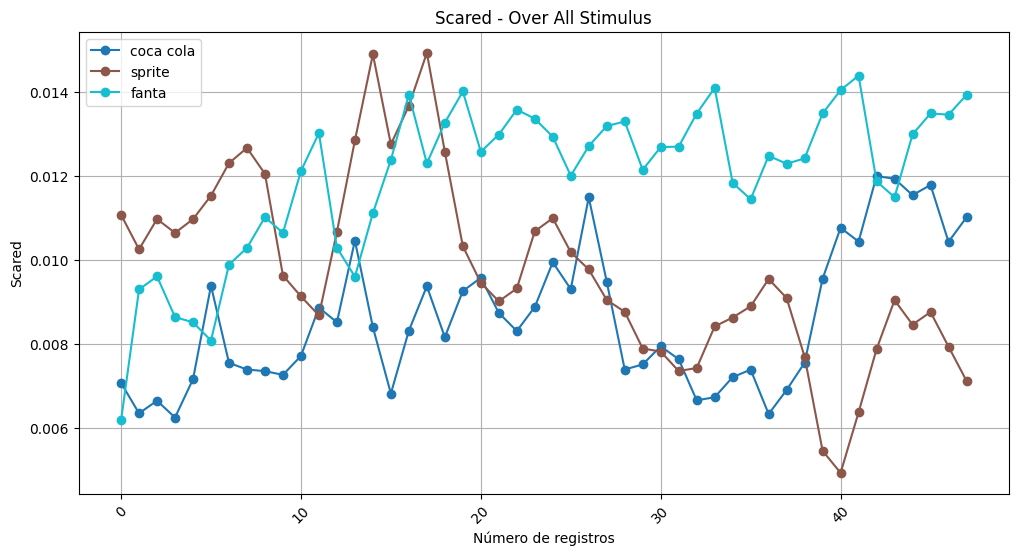

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.003879933917368421), np.float64(0.003975528490263157), np.float64(0.003990996645877193), np.float64(0.004778093335421053), np.float64(0.005128048253614034), np.float64(0.005502635692803573), np.float64(0.005741634253947369), np.float64(0.004914988979877192), np.float64(0.006408361035491227), np.float64(0.0053599995852807005), np.float64(0.006348471831449124), np.float64(0.008992209754982458), np.float64(0.011808758955000003), np.float64(0.007493508769877192), np.float64(0.006223379563157892), np.float64(0.006268110298385963), np.float64(0.007307616112824563), np.float64(0.0064772826399473685), np.float64(0.008609979271385966), np.float64(0.006931400096824563), np.float64(0.006536982930175438), np.float64(0.008060518911578947), np.float64(0.007523002246666665), np.float64(0.00911134232708772), np.float64(0.00644606747585965), np.float64(0.007595370510140349), np.float64(0.007781523241140352), np.float64(0.00866350314805263)

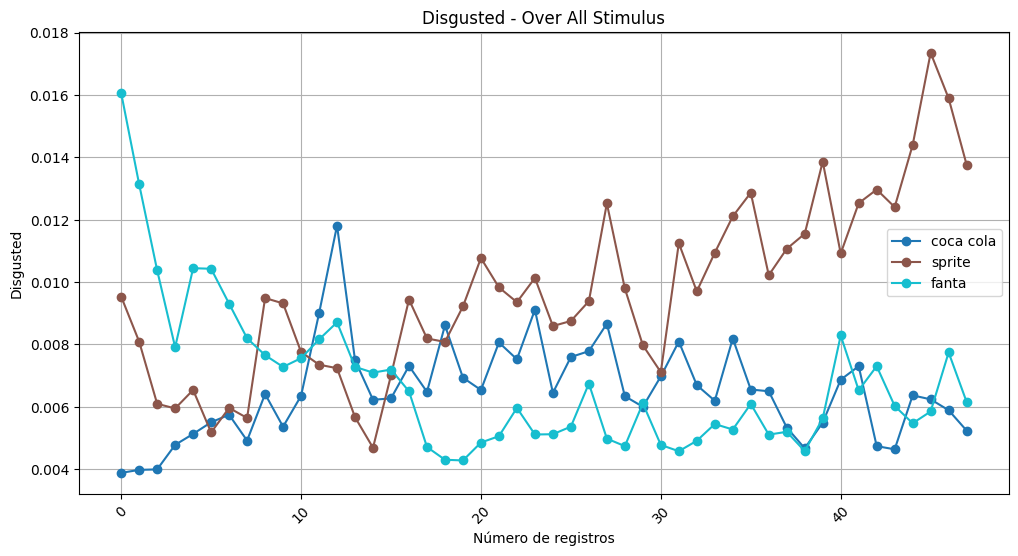

In [ ]:
for emotion in emotions:
    averages_dict, min_length = extract_column_averages(df_filtered, list(specific_times_stimulus.values()), emotion, list(specific_times_stimulus.keys()))

    # Imprimir los resultados
    print("Promedios por estímulo:")
    for stimulus, avg_list in averages_dict.items():
        print(f"{stimulus} ({len(avg_list)} elementos): {avg_list}")

    print(f"El estímulo con menos elementos tiene {min_length} valores.")
    # Llamar a la función con el diccionario de promedios y los detalles del gráfico.
    plot_averages(averages_dict, f'{emotion} - Over All Stimulus', emotion)

## Diagramas de caja de emociones por estímulo

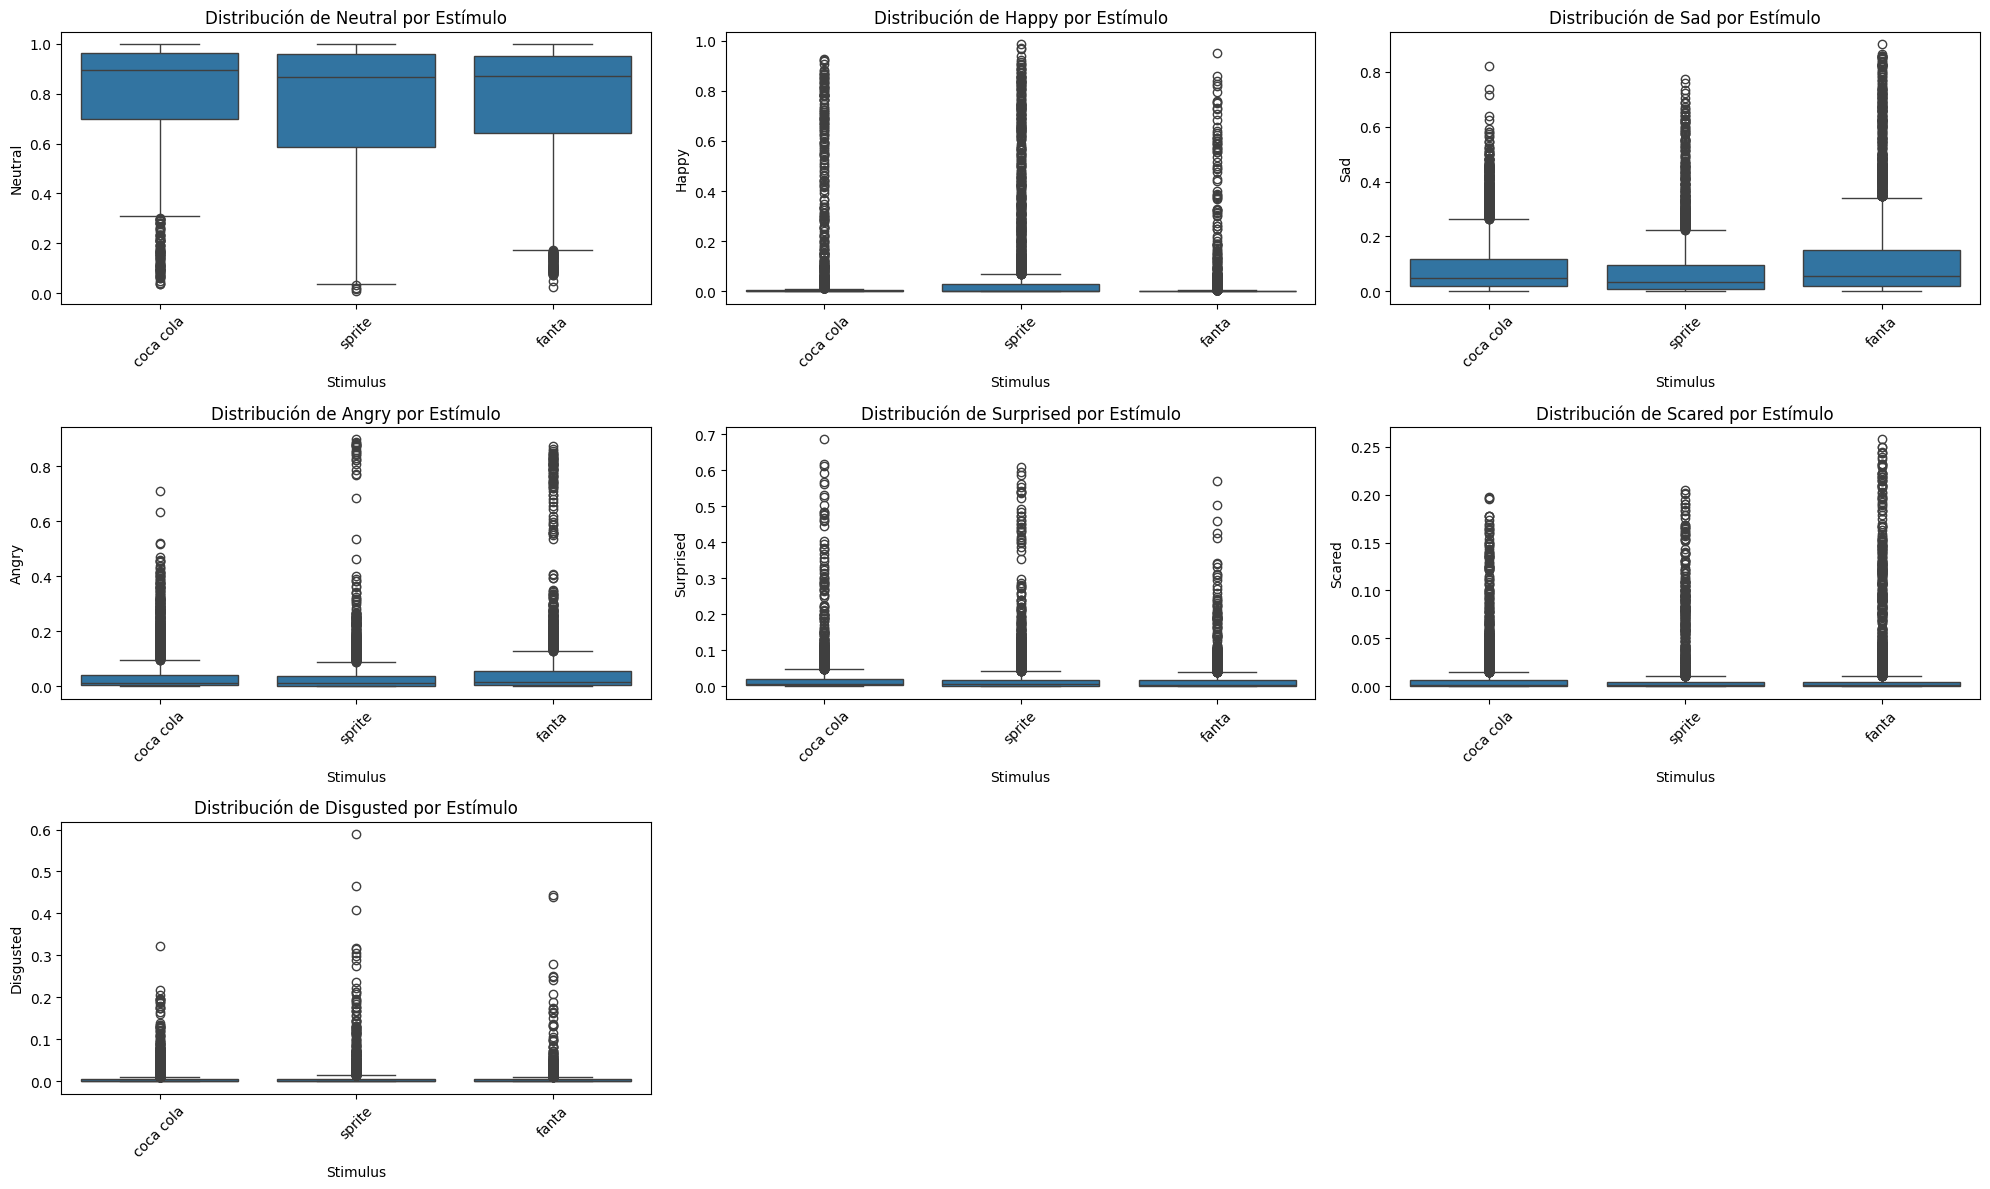

In [ ]:
# Crear una figura para los box plots
plt.figure(figsize=(20, 12))  # Ajustar tamaño de la figura

# Usar un bucle para crear un box plot para cada emoción
for i, emotion in enumerate(emotions):
    plt.subplot(3, 3, i + 1)  # Crear subplots, ajustando a 3 filas y 3 columnas
    sns.boxplot(x='Stimulus', y=emotion, data=df_filtered)  # Graficar boxplot de cada emoción por estímulo
    plt.title(f'Distribución de {emotion} por Estímulo')
    plt.xticks(rotation=45)  # Rotar etiquetas en el eje X para mejor visualización
    plt.tight_layout()  # Asegurar que no se sobrepongan los gráficos

# Mostrar todos los gráficos
plt.show()

#**Valence y Arousal**

coca cola:['00:00:05.000', '00:00:06.000', '00:00:07.000', '00:00:08.000', '00:00:09.000', '00:00:10.000', '00:00:11.000', '00:00:12.000', '00:00:13.000', '00:00:14.000', '00:00:15.000', '00:00:16.000', '00:00:17.000', '00:00:18.000', '00:00:19.000', '00:00:20.000', '00:00:21.000', '00:00:22.000', '00:00:23.000', '00:00:24.000', '00:00:25.000', '00:00:26.000', '00:00:27.000', '00:00:28.000', '00:00:29.000', '00:00:30.000', '00:00:31.000', '00:00:32.000', '00:00:33.000', '00:00:34.000', '00:00:35.000', '00:00:36.000', '00:00:37.000', '00:00:38.000', '00:00:39.000', '00:00:40.000', '00:00:41.000', '00:00:42.000', '00:00:43.000', '00:00:44.000', '00:00:45.000', '00:00:46.000', '00:00:47.000', '00:00:48.000', '00:00:49.000', '00:00:50.000', '00:00:51.000', '00:00:52.000', '00:00:53.000', '00:00:54.000', '00:00:55.000', '00:00:56.000', '00:00:57.000', '00:00:58.000', '00:00:59.000', '00:01:00.000', '00:01:01.000', '00:01:02.000', '00:01:03.000', '00:01:04.000']


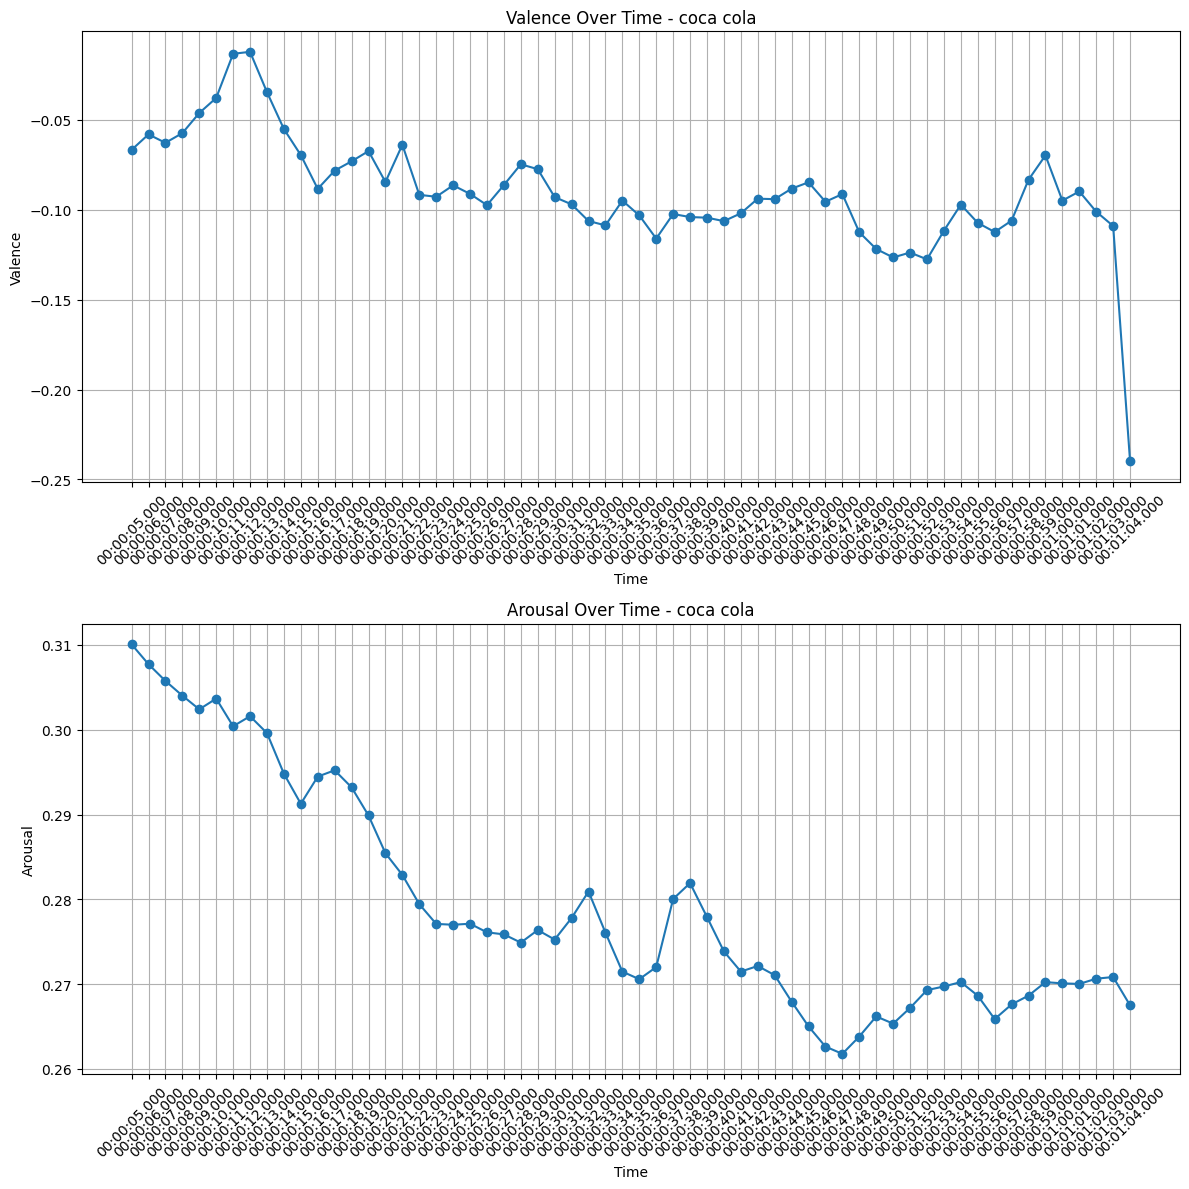

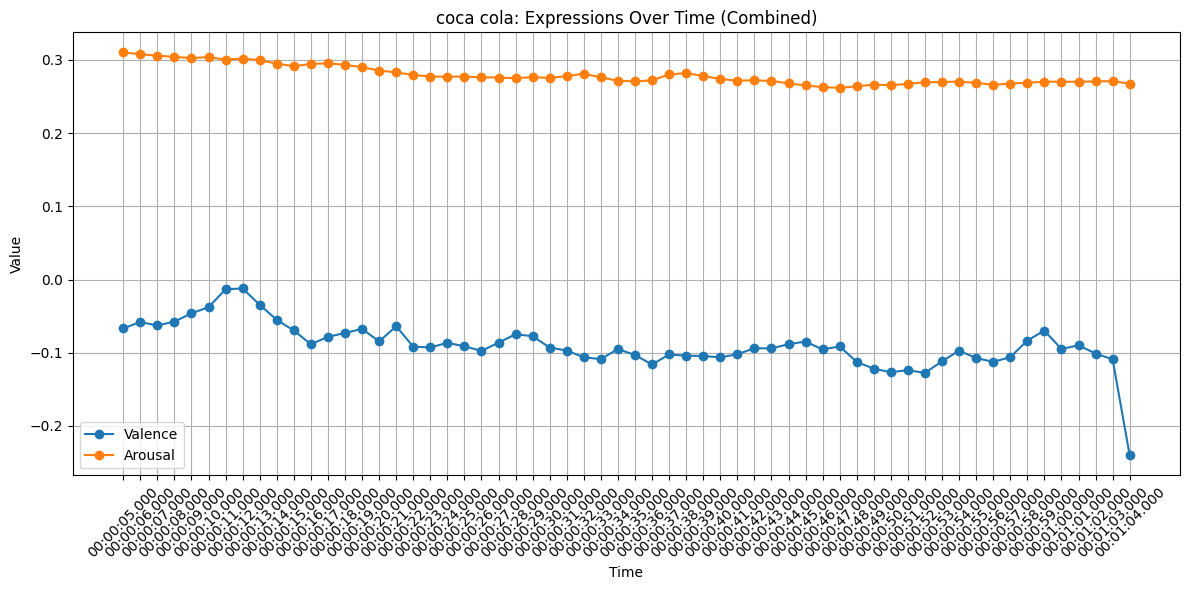

sprite:['00:01:09.000', '00:01:10.000', '00:01:11.000', '00:01:12.000', '00:01:13.000', '00:01:14.000', '00:01:15.000', '00:01:16.000', '00:01:17.000', '00:01:18.000', '00:01:19.000', '00:01:20.000', '00:01:21.000', '00:01:22.000', '00:01:23.000', '00:01:24.000', '00:01:25.000', '00:01:26.000', '00:01:27.000', '00:01:28.000', '00:01:29.000', '00:01:30.000', '00:01:31.000', '00:01:32.000', '00:01:33.000', '00:01:34.000', '00:01:35.000', '00:01:36.000', '00:01:37.000', '00:01:38.000', '00:01:39.000', '00:01:40.000', '00:01:41.000', '00:01:42.000', '00:01:43.000', '00:01:44.000', '00:01:45.000', '00:01:46.000', '00:01:47.000', '00:01:48.000', '00:01:49.000', '00:01:50.000', '00:01:51.000', '00:01:52.000', '00:01:53.000', '00:01:54.000', '00:01:55.000', '00:01:56.000']


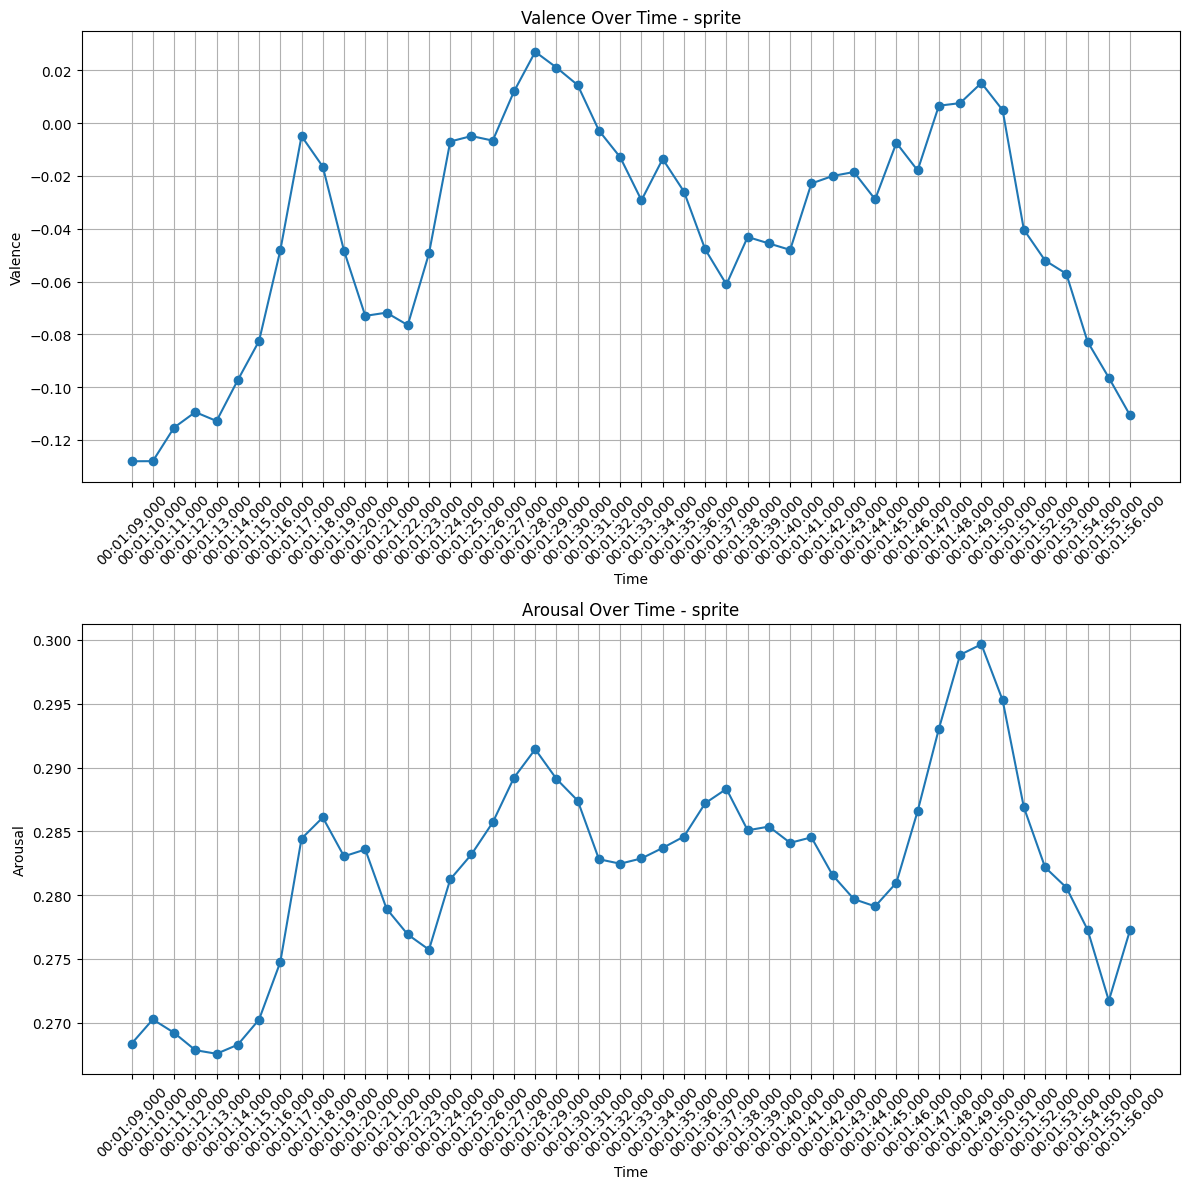

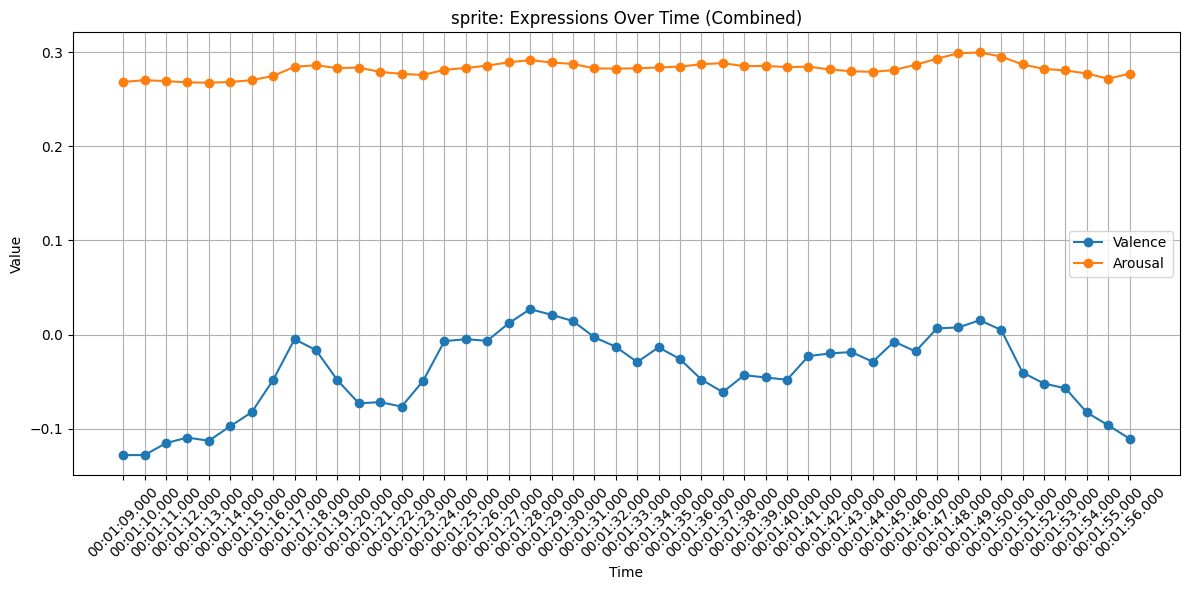

fanta:['00:02:01.000', '00:02:02.000', '00:02:03.000', '00:02:04.000', '00:02:05.000', '00:02:06.000', '00:02:07.000', '00:02:08.000', '00:02:09.000', '00:02:10.000', '00:02:11.000', '00:02:12.000', '00:02:13.000', '00:02:14.000', '00:02:15.000', '00:02:16.000', '00:02:17.000', '00:02:18.000', '00:02:19.000', '00:02:20.000', '00:02:21.000', '00:02:22.000', '00:02:23.000', '00:02:24.000', '00:02:25.000', '00:02:26.000', '00:02:27.000', '00:02:28.000', '00:02:29.000', '00:02:30.000', '00:02:31.000', '00:02:32.000', '00:02:33.000', '00:02:34.000', '00:02:35.000', '00:02:36.000', '00:02:37.000', '00:02:38.000', '00:02:39.000', '00:02:40.000', '00:02:41.000', '00:02:42.000', '00:02:43.000', '00:02:44.000', '00:02:45.000', '00:02:46.000', '00:02:47.000', '00:02:48.000', '00:02:49.000', '00:02:50.000', '00:02:51.000', '00:02:52.000', '00:02:53.000', '00:02:54.000', '00:02:55.000', '00:02:56.000', '00:02:57.000', '00:02:58.000', '00:02:59.000', '00:03:00.000']


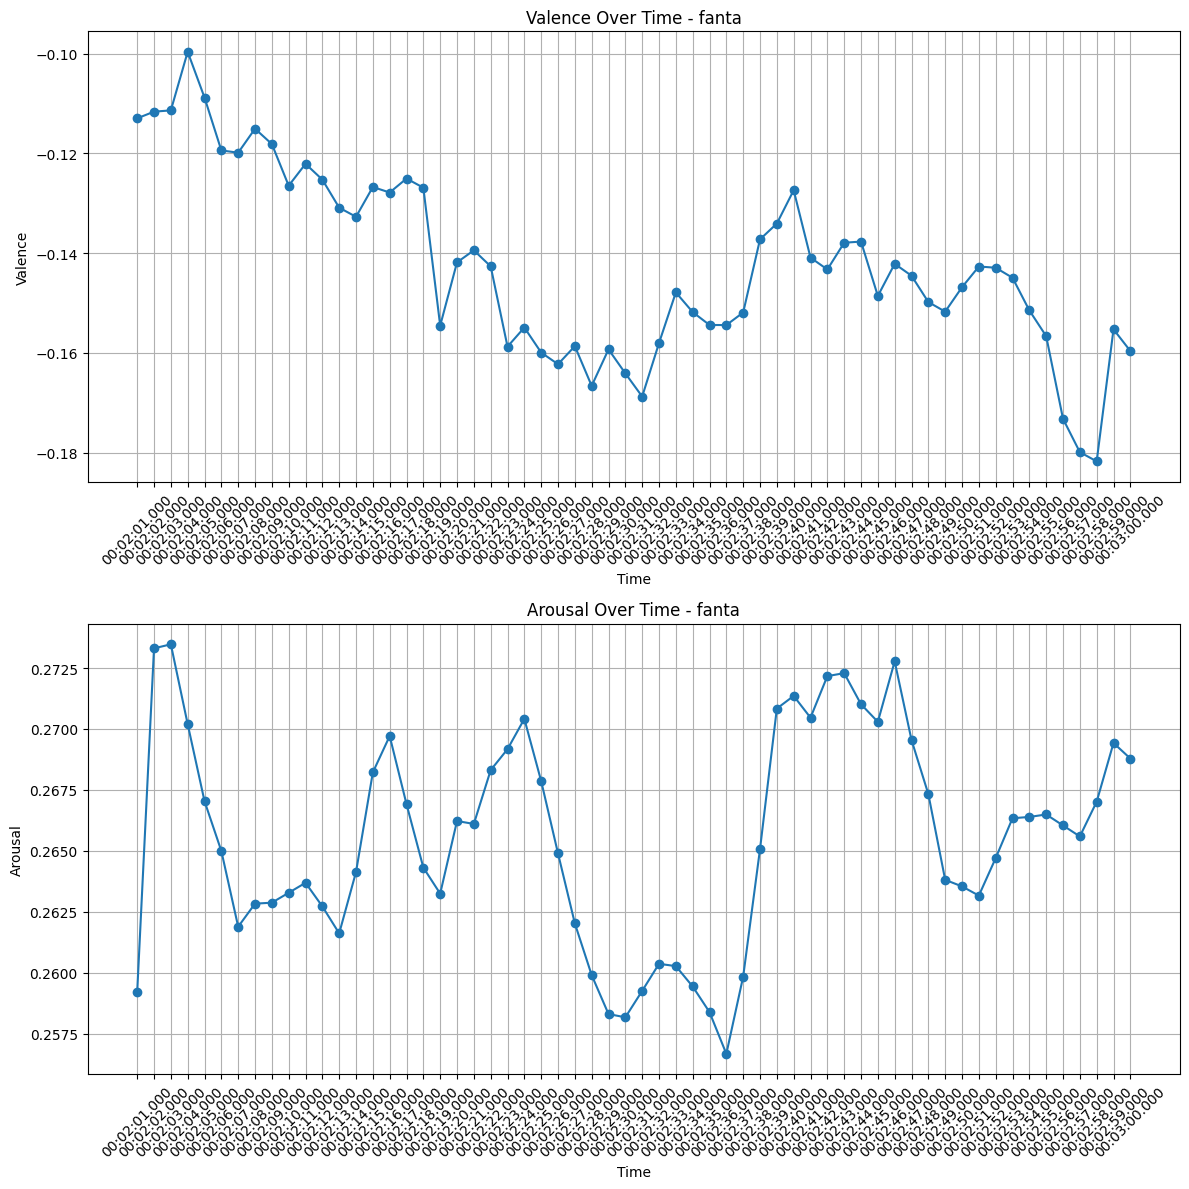

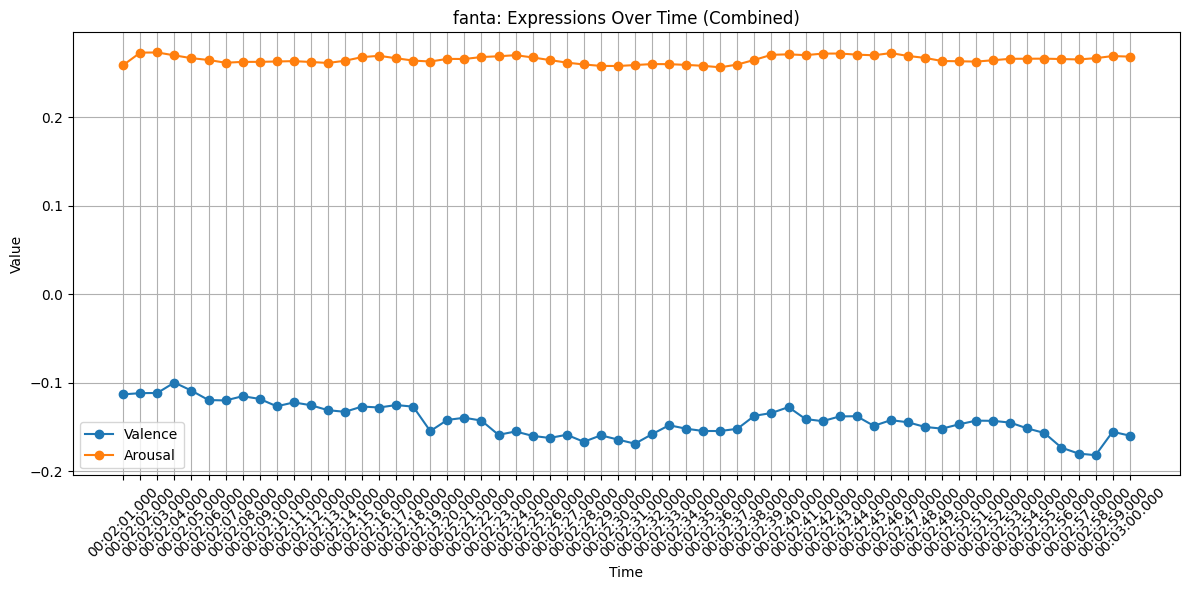

In [ ]:
# Llamar a la función para realizar la imputación con media
for specific_times in specific_times_stimulus:
    print(f"{specific_times}:{specific_times_stimulus[specific_times]}")
    # Usar la función para graficar con gráficos separados
    plot_expression_over_time(df_filtered, specific_times_stimulus[specific_times], val_aro, stimulus_title=f"{specific_times}", combine_graphs=False)

    # Usar la función para graficar con gráficos combinados en una sola gráfica
    plot_expression_over_time(df_filtered, specific_times_stimulus[specific_times], val_aro, stimulus_title=f"{specific_times}", combine_graphs=True)

## Valencia de los estímulos en una sola gráfica

In [ ]:
print(list(specific_times_stimulus.keys()))
print(list(specific_times_stimulus.values()))

['coca cola', 'sprite', 'fanta']
[['00:00:05.000', '00:00:06.000', '00:00:07.000', '00:00:08.000', '00:00:09.000', '00:00:10.000', '00:00:11.000', '00:00:12.000', '00:00:13.000', '00:00:14.000', '00:00:15.000', '00:00:16.000', '00:00:17.000', '00:00:18.000', '00:00:19.000', '00:00:20.000', '00:00:21.000', '00:00:22.000', '00:00:23.000', '00:00:24.000', '00:00:25.000', '00:00:26.000', '00:00:27.000', '00:00:28.000', '00:00:29.000', '00:00:30.000', '00:00:31.000', '00:00:32.000', '00:00:33.000', '00:00:34.000', '00:00:35.000', '00:00:36.000', '00:00:37.000', '00:00:38.000', '00:00:39.000', '00:00:40.000', '00:00:41.000', '00:00:42.000', '00:00:43.000', '00:00:44.000', '00:00:45.000', '00:00:46.000', '00:00:47.000', '00:00:48.000', '00:00:49.000', '00:00:50.000', '00:00:51.000', '00:00:52.000', '00:00:53.000', '00:00:54.000', '00:00:55.000', '00:00:56.000', '00:00:57.000', '00:00:58.000', '00:00:59.000', '00:01:00.000', '00:01:01.000', '00:01:02.000', '00:01:03.000', '00:01:04.000'], ['00

Promedios por estímulo:
coca cola (60 elementos): [np.float64(-0.06672056958771931), np.float64(-0.058110862022807026), np.float64(-0.062796567877193), np.float64(-0.057405515498245616), np.float64(-0.04622398857894738), np.float64(-0.037838942803571425), np.float64(-0.01330456405263157), np.float64(-0.012190031929824562), np.float64(-0.03460310443859649), np.float64(-0.05511129131578945), np.float64(-0.0696270868263158), np.float64(-0.08839852965614037), np.float64(-0.07824743194736838), np.float64(-0.07308028754385963), np.float64(-0.06739847461403511), np.float64(-0.08458622250526317), np.float64(-0.06387025385789476), np.float64(-0.09171229145614036), np.float64(-0.09279569969473686), np.float64(-0.08642902744912281), np.float64(-0.09120465499824562), np.float64(-0.09745720051929824), np.float64(-0.0862721749280702), np.float64(-0.074729082554386), np.float64(-0.07744986536842108), np.float64(-0.09297419464912282), np.float64(-0.0970172983157895), np.float64(-0.10626229217543862), 

<ipython-input-3-84ab4f82d6a8>:260: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(averages_dict))  # Obtener un colormap que genere suficientes colores


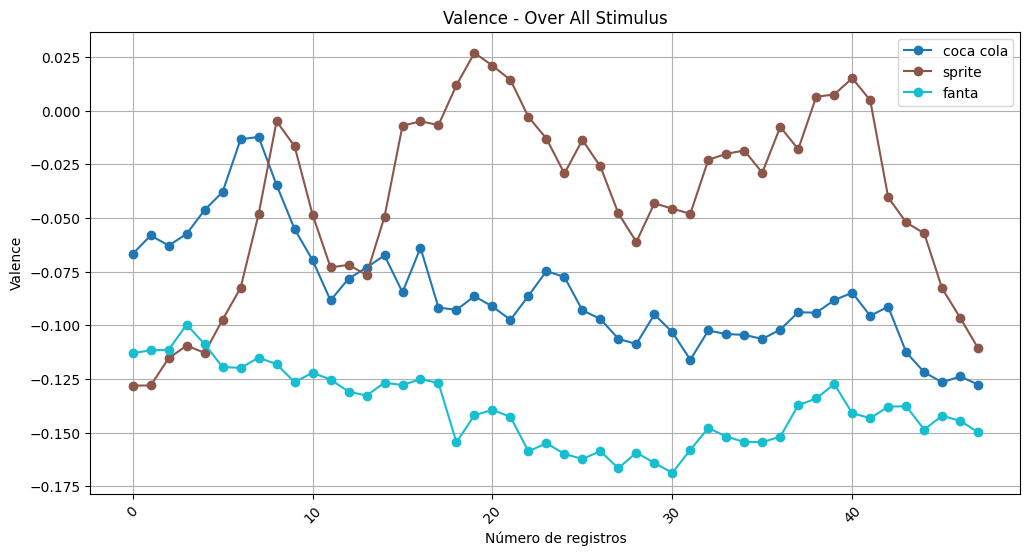

In [ ]:
# Llamada a la función para obtener los promedios de la columna 'Valence'
averages_dict, min_length = extract_column_averages(df_filtered, list(specific_times_stimulus.values()), 'Valence', list(specific_times_stimulus.keys()))

# Imprimir los resultados
print("Promedios por estímulo:")
for stimulus, avg_list in averages_dict.items():
    print(f"{stimulus} ({len(avg_list)} elementos): {avg_list}")

print(f"El estímulo con menos elementos tiene {min_length} valores.")
# Llamar a la función con el diccionario de promedios y los detalles del gráfico.
plot_averages(averages_dict, 'Valence - Over All Stimulus', 'Valence')

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.3100641070175438), np.float64(0.3077183754385965), np.float64(0.30574697192982464), np.float64(0.30401346315789485), np.float64(0.3023983543859649), np.float64(0.30366414464285724), np.float64(0.30040120350877186), np.float64(0.30158747017543863), np.float64(0.2995999438596491), np.float64(0.29481376491228073), np.float64(0.2912656561403508), np.float64(0.29446827192982455), np.float64(0.2952120543859649), np.float64(0.29320252807017555), np.float64(0.28988296315789464), np.float64(0.2854400614035088), np.float64(0.2828751631578947), np.float64(0.279432249122807), np.float64(0.27710314736842107), np.float64(0.2770024543859649), np.float64(0.2771233789473685), np.float64(0.27610911929824566), np.float64(0.2758689526315789), np.float64(0.2748962263157894), np.float64(0.27637634210526313), np.float64(0.27525777368421056), np.float64(0.2777994421052632), np.float64(0.28092144385964907), np.float64(0.2760764929824561), np.float

<ipython-input-3-84ab4f82d6a8>:260: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(averages_dict))  # Obtener un colormap que genere suficientes colores


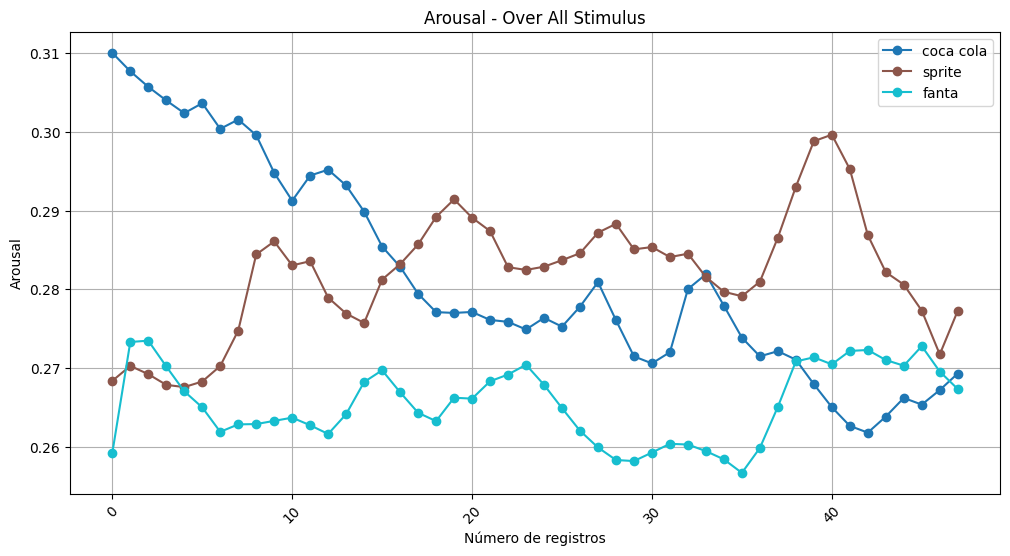

In [ ]:
# Llamada a la función para obtener los promedios de la columna 'Arousal'
averages_dict, min_length = extract_column_averages(df_filtered, list(specific_times_stimulus.values()), 'Arousal', list(specific_times_stimulus.keys()))

# Imprimir los resultados
print("Promedios por estímulo:")
for stimulus, avg_list in averages_dict.items():
    print(f"{stimulus} ({len(avg_list)} elementos): {avg_list}")

print(f"El estímulo con menos elementos tiene {min_length} valores.")
# Llamar a la función con el diccionario de promedios y los detalles del gráfico.
plot_averages(averages_dict, 'Arousal - Over All Stimulus', 'Arousal')

## Diagramas de caja de Valence Arousal por estímulo

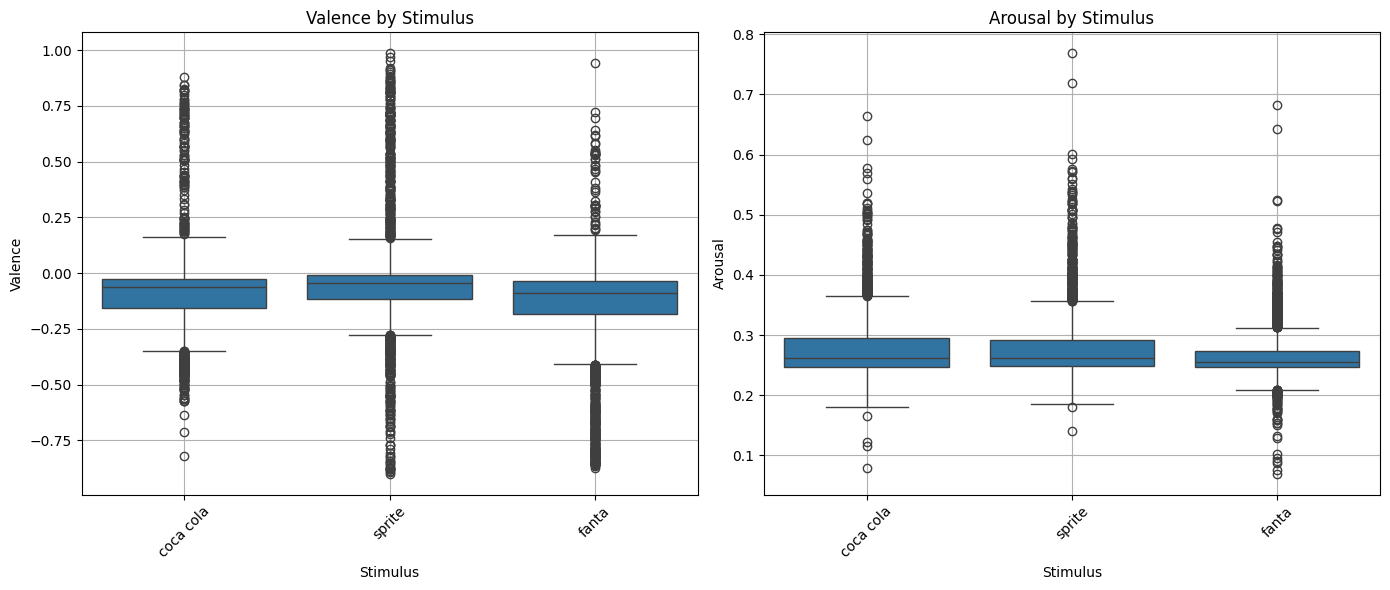

In [ ]:
# Crear una figura para los boxplots
plt.figure(figsize=(14, 6))

# Diagrama de caja para Valence por estímulo
plt.subplot(1, 2, 1)  # Para dos gráficos lado a lado
sns.boxplot(x='Stimulus', y='Valence', data=df_filtered)
plt.title('Valence by Stimulus')
plt.xticks(rotation=45)
plt.grid(True)

# Diagrama de caja para Arousal por estímulo
plt.subplot(1, 2, 2)
sns.boxplot(x='Stimulus', y='Arousal', data=df_filtered)
plt.title('Arousal by Stimulus')
plt.xticks(rotation=45)
plt.grid(True)

# Ajustar los espacios entre gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

## Mapas de calor para Valencia y Arousal



coca cola:['00:00:05.000', '00:00:06.000', '00:00:07.000', '00:00:08.000', '00:00:09.000', '00:00:10.000', '00:00:11.000', '00:00:12.000', '00:00:13.000', '00:00:14.000', '00:00:15.000', '00:00:16.000', '00:00:17.000', '00:00:18.000', '00:00:19.000', '00:00:20.000', '00:00:21.000', '00:00:22.000', '00:00:23.000', '00:00:24.000', '00:00:25.000', '00:00:26.000', '00:00:27.000', '00:00:28.000', '00:00:29.000', '00:00:30.000', '00:00:31.000', '00:00:32.000', '00:00:33.000', '00:00:34.000', '00:00:35.000', '00:00:36.000', '00:00:37.000', '00:00:38.000', '00:00:39.000', '00:00:40.000', '00:00:41.000', '00:00:42.000', '00:00:43.000', '00:00:44.000', '00:00:45.000', '00:00:46.000', '00:00:47.000', '00:00:48.000', '00:00:49.000', '00:00:50.000', '00:00:51.000', '00:00:52.000', '00:00:53.000', '00:00:54.000', '00:00:55.000', '00:00:56.000', '00:00:57.000', '00:00:58.000', '00:00:59.000', '00:01:00.000', '00:01:01.000', '00:01:02.000', '00:01:03.000', '00:01:04.000']


<Figure size 1000x800 with 0 Axes>

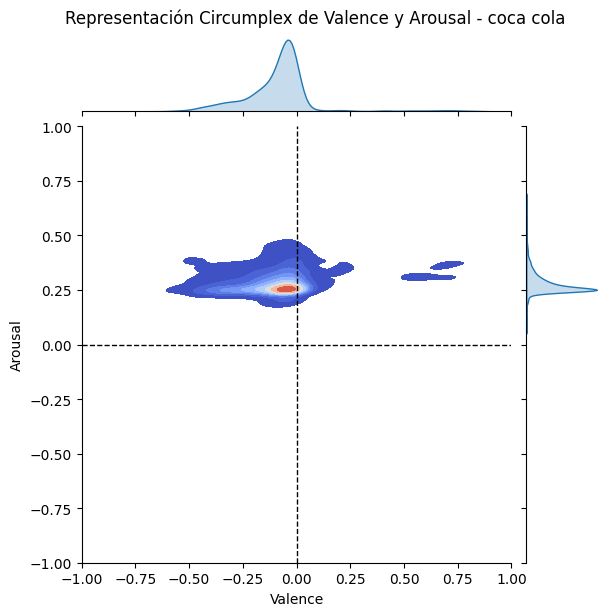

sprite:['00:01:09.000', '00:01:10.000', '00:01:11.000', '00:01:12.000', '00:01:13.000', '00:01:14.000', '00:01:15.000', '00:01:16.000', '00:01:17.000', '00:01:18.000', '00:01:19.000', '00:01:20.000', '00:01:21.000', '00:01:22.000', '00:01:23.000', '00:01:24.000', '00:01:25.000', '00:01:26.000', '00:01:27.000', '00:01:28.000', '00:01:29.000', '00:01:30.000', '00:01:31.000', '00:01:32.000', '00:01:33.000', '00:01:34.000', '00:01:35.000', '00:01:36.000', '00:01:37.000', '00:01:38.000', '00:01:39.000', '00:01:40.000', '00:01:41.000', '00:01:42.000', '00:01:43.000', '00:01:44.000', '00:01:45.000', '00:01:46.000', '00:01:47.000', '00:01:48.000', '00:01:49.000', '00:01:50.000', '00:01:51.000', '00:01:52.000', '00:01:53.000', '00:01:54.000', '00:01:55.000', '00:01:56.000']


<Figure size 1000x800 with 0 Axes>

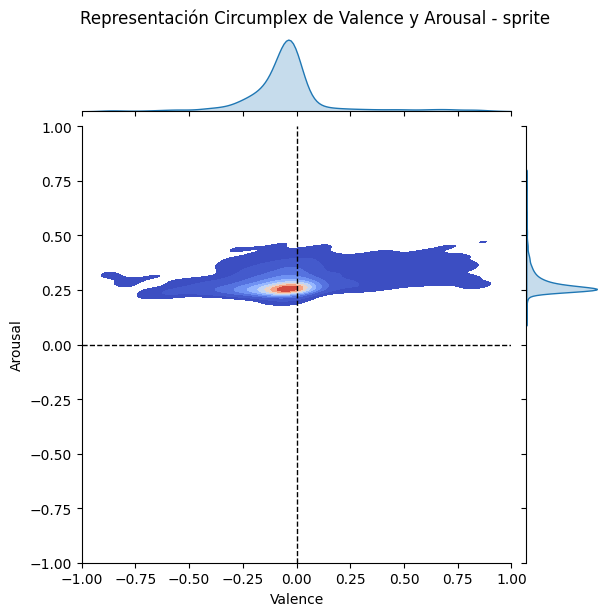

fanta:['00:02:01.000', '00:02:02.000', '00:02:03.000', '00:02:04.000', '00:02:05.000', '00:02:06.000', '00:02:07.000', '00:02:08.000', '00:02:09.000', '00:02:10.000', '00:02:11.000', '00:02:12.000', '00:02:13.000', '00:02:14.000', '00:02:15.000', '00:02:16.000', '00:02:17.000', '00:02:18.000', '00:02:19.000', '00:02:20.000', '00:02:21.000', '00:02:22.000', '00:02:23.000', '00:02:24.000', '00:02:25.000', '00:02:26.000', '00:02:27.000', '00:02:28.000', '00:02:29.000', '00:02:30.000', '00:02:31.000', '00:02:32.000', '00:02:33.000', '00:02:34.000', '00:02:35.000', '00:02:36.000', '00:02:37.000', '00:02:38.000', '00:02:39.000', '00:02:40.000', '00:02:41.000', '00:02:42.000', '00:02:43.000', '00:02:44.000', '00:02:45.000', '00:02:46.000', '00:02:47.000', '00:02:48.000', '00:02:49.000', '00:02:50.000', '00:02:51.000', '00:02:52.000', '00:02:53.000', '00:02:54.000', '00:02:55.000', '00:02:56.000', '00:02:57.000', '00:02:58.000', '00:02:59.000', '00:03:00.000']


<Figure size 1000x800 with 0 Axes>

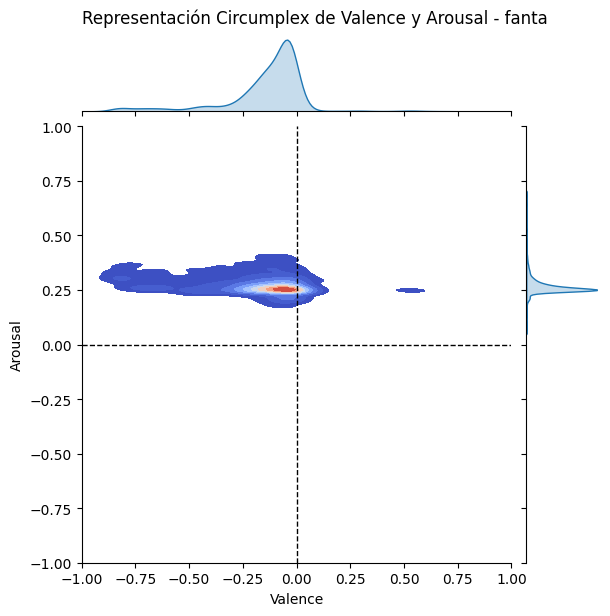

In [ ]:
# Llamar a la función para realizar la imputación con media
for specific_times in specific_times_stimulus:
    print(f"{specific_times}:{specific_times_stimulus[specific_times]}")

    valence_data_stimulus1 = df[df['Time'].isin(specific_times_stimulus[specific_times])]['Valence']
    arousal_data_stimulus1 = df[df['Time'].isin(specific_times_stimulus[specific_times])]['Arousal']

    # Generar el mapa de calor para el estímulo 1
    plot_heatmap_for_valence_arousal(valence_data_stimulus1, arousal_data_stimulus1, specific_times)

#**Custom Expression**

coca cola:['00:00:05.000', '00:00:06.000', '00:00:07.000', '00:00:08.000', '00:00:09.000', '00:00:10.000', '00:00:11.000', '00:00:12.000', '00:00:13.000', '00:00:14.000', '00:00:15.000', '00:00:16.000', '00:00:17.000', '00:00:18.000', '00:00:19.000', '00:00:20.000', '00:00:21.000', '00:00:22.000', '00:00:23.000', '00:00:24.000', '00:00:25.000', '00:00:26.000', '00:00:27.000', '00:00:28.000', '00:00:29.000', '00:00:30.000', '00:00:31.000', '00:00:32.000', '00:00:33.000', '00:00:34.000', '00:00:35.000', '00:00:36.000', '00:00:37.000', '00:00:38.000', '00:00:39.000', '00:00:40.000', '00:00:41.000', '00:00:42.000', '00:00:43.000', '00:00:44.000', '00:00:45.000', '00:00:46.000', '00:00:47.000', '00:00:48.000', '00:00:49.000', '00:00:50.000', '00:00:51.000', '00:00:52.000', '00:00:53.000', '00:00:54.000', '00:00:55.000', '00:00:56.000', '00:00:57.000', '00:00:58.000', '00:00:59.000', '00:01:00.000', '00:01:01.000', '00:01:02.000', '00:01:03.000', '00:01:04.000']


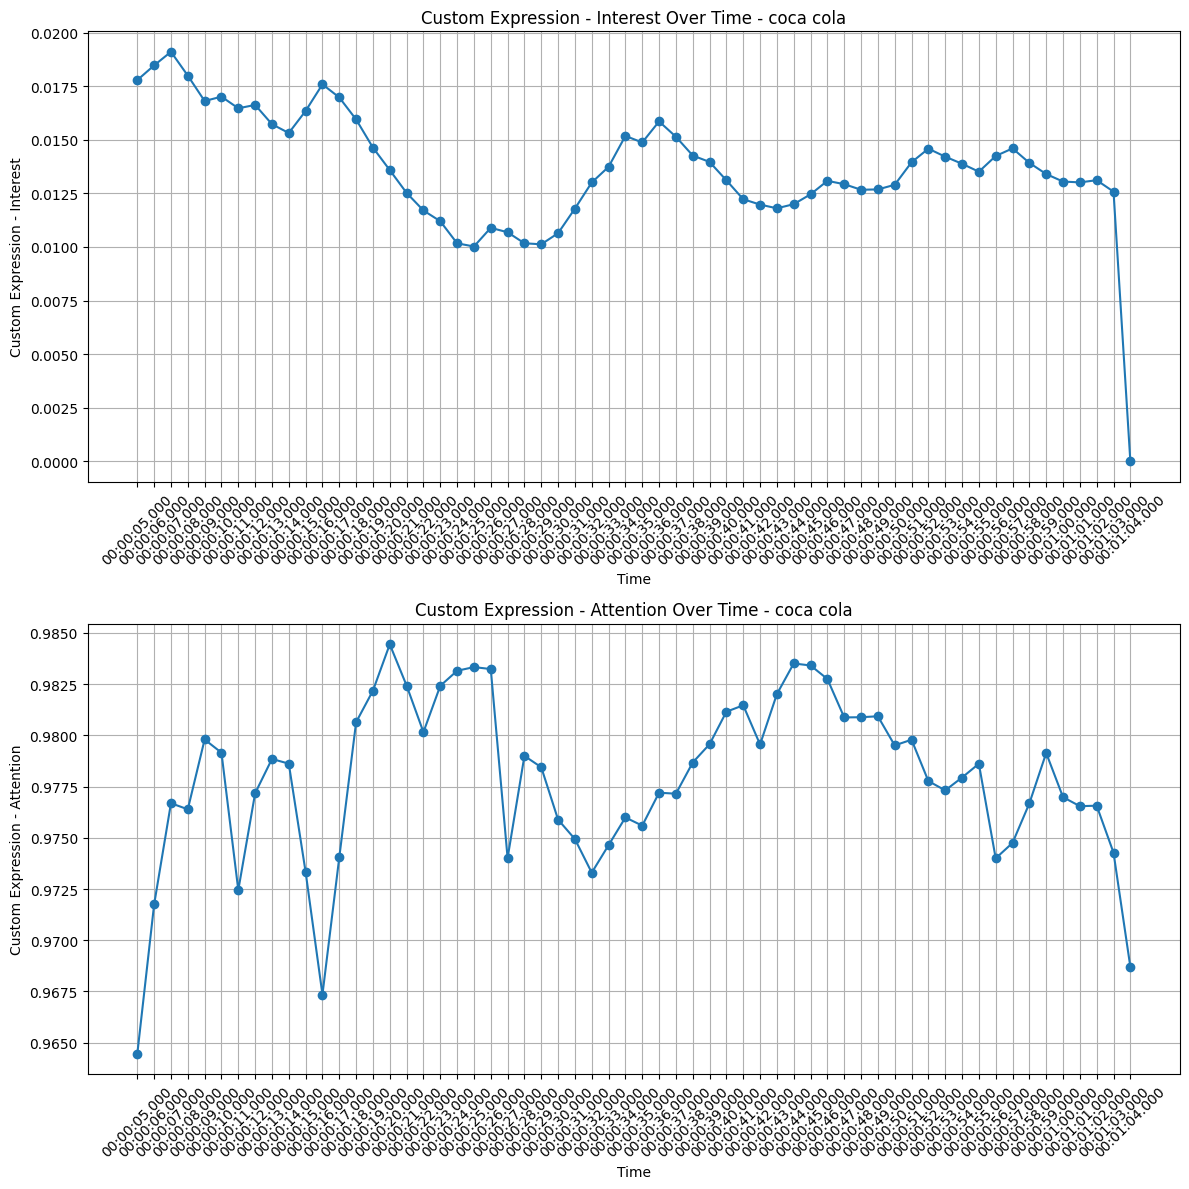

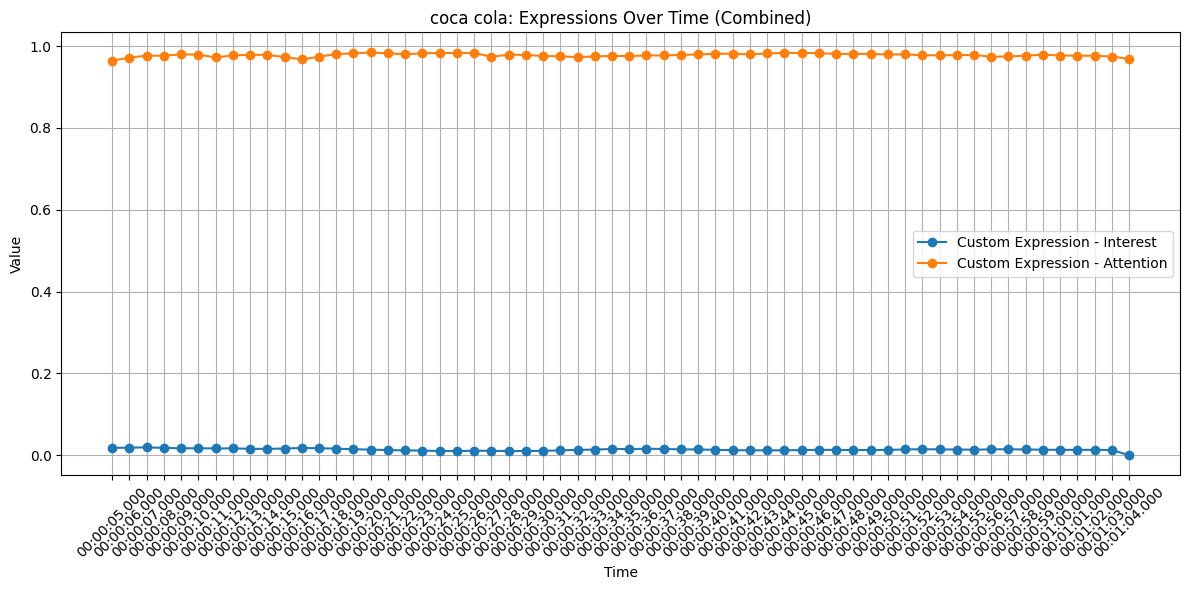

sprite:['00:01:09.000', '00:01:10.000', '00:01:11.000', '00:01:12.000', '00:01:13.000', '00:01:14.000', '00:01:15.000', '00:01:16.000', '00:01:17.000', '00:01:18.000', '00:01:19.000', '00:01:20.000', '00:01:21.000', '00:01:22.000', '00:01:23.000', '00:01:24.000', '00:01:25.000', '00:01:26.000', '00:01:27.000', '00:01:28.000', '00:01:29.000', '00:01:30.000', '00:01:31.000', '00:01:32.000', '00:01:33.000', '00:01:34.000', '00:01:35.000', '00:01:36.000', '00:01:37.000', '00:01:38.000', '00:01:39.000', '00:01:40.000', '00:01:41.000', '00:01:42.000', '00:01:43.000', '00:01:44.000', '00:01:45.000', '00:01:46.000', '00:01:47.000', '00:01:48.000', '00:01:49.000', '00:01:50.000', '00:01:51.000', '00:01:52.000', '00:01:53.000', '00:01:54.000', '00:01:55.000', '00:01:56.000']


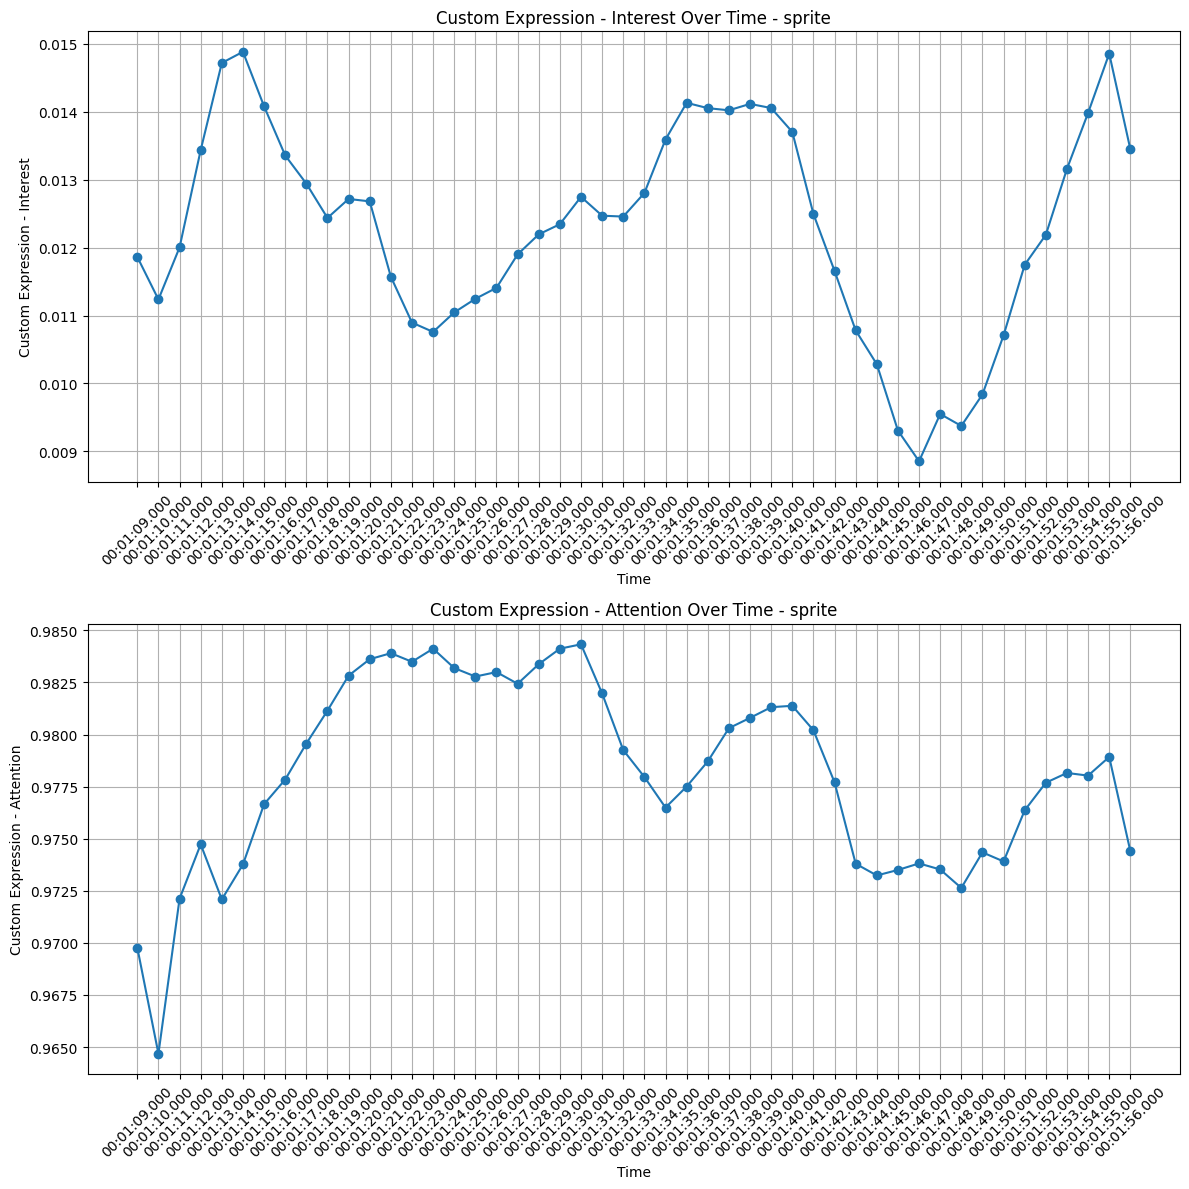

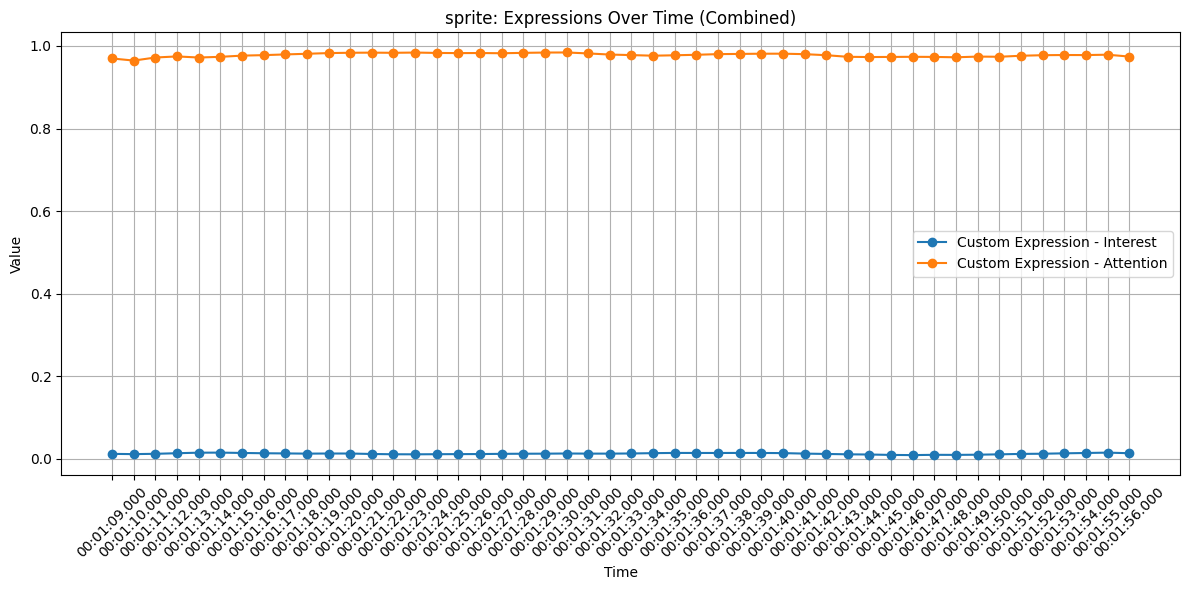

fanta:['00:02:01.000', '00:02:02.000', '00:02:03.000', '00:02:04.000', '00:02:05.000', '00:02:06.000', '00:02:07.000', '00:02:08.000', '00:02:09.000', '00:02:10.000', '00:02:11.000', '00:02:12.000', '00:02:13.000', '00:02:14.000', '00:02:15.000', '00:02:16.000', '00:02:17.000', '00:02:18.000', '00:02:19.000', '00:02:20.000', '00:02:21.000', '00:02:22.000', '00:02:23.000', '00:02:24.000', '00:02:25.000', '00:02:26.000', '00:02:27.000', '00:02:28.000', '00:02:29.000', '00:02:30.000', '00:02:31.000', '00:02:32.000', '00:02:33.000', '00:02:34.000', '00:02:35.000', '00:02:36.000', '00:02:37.000', '00:02:38.000', '00:02:39.000', '00:02:40.000', '00:02:41.000', '00:02:42.000', '00:02:43.000', '00:02:44.000', '00:02:45.000', '00:02:46.000', '00:02:47.000', '00:02:48.000', '00:02:49.000', '00:02:50.000', '00:02:51.000', '00:02:52.000', '00:02:53.000', '00:02:54.000', '00:02:55.000', '00:02:56.000', '00:02:57.000', '00:02:58.000', '00:02:59.000', '00:03:00.000']


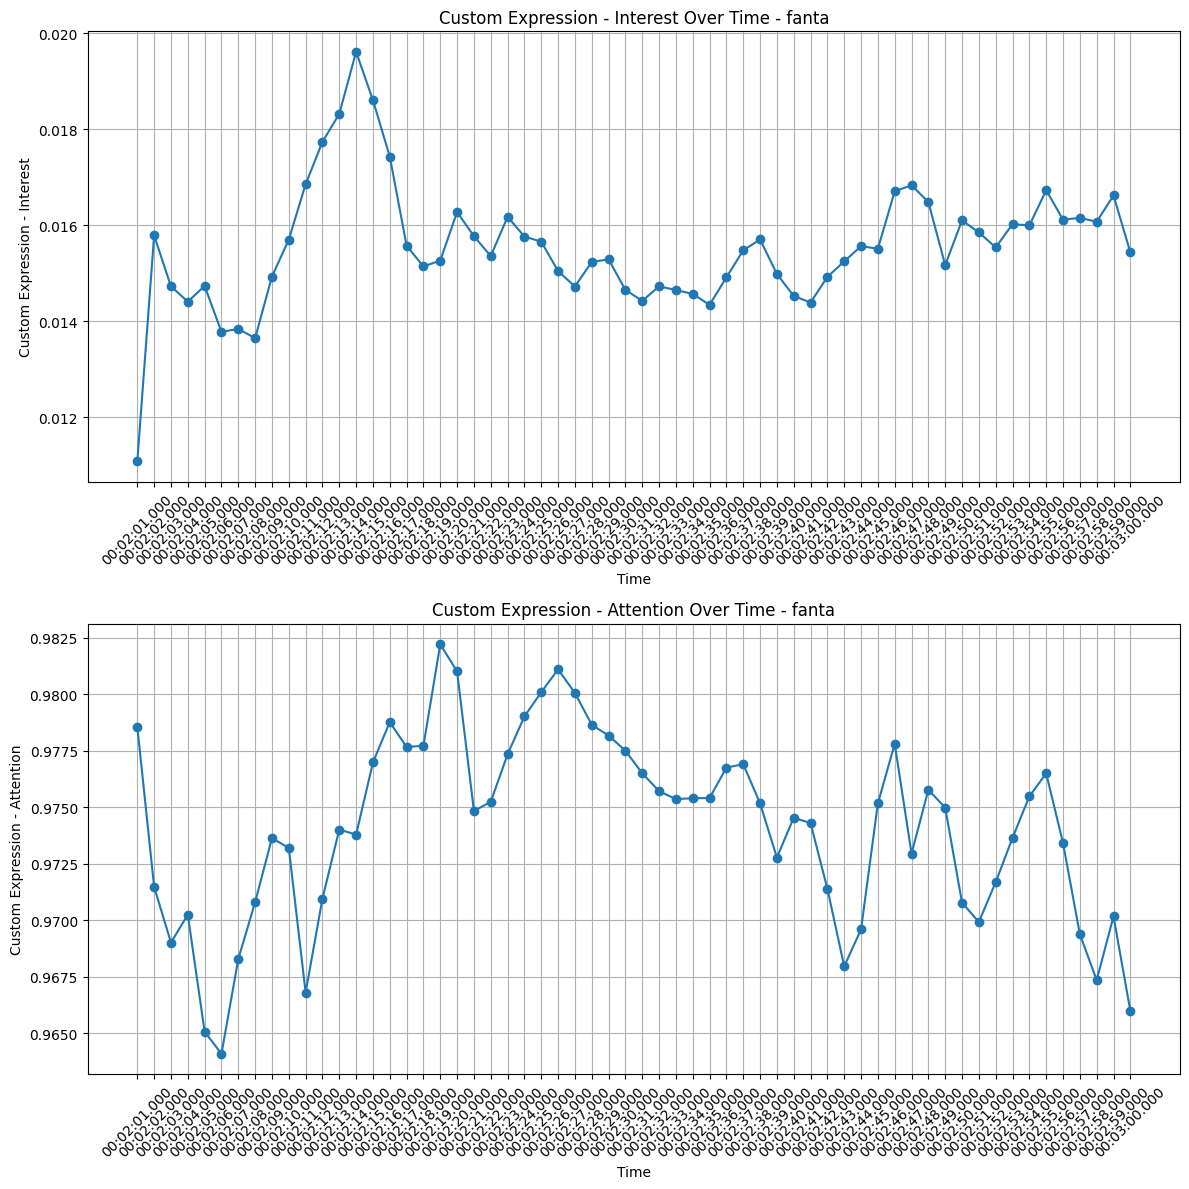

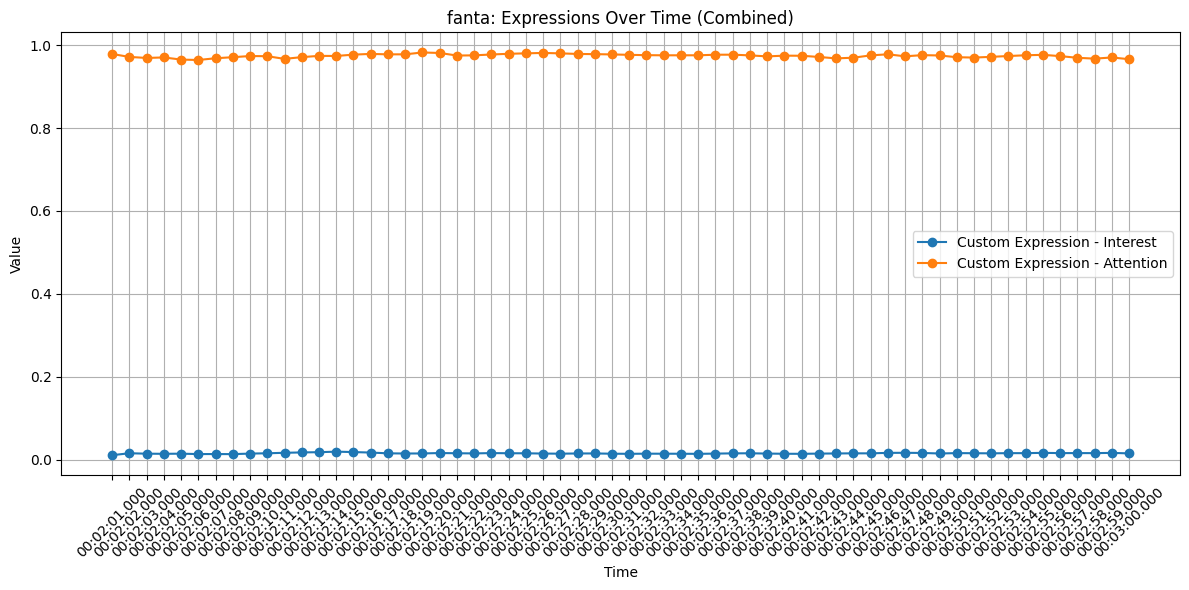

In [ ]:
# Llamar a la función para realizar la imputación con media
for specific_times in specific_times_stimulus:
    print(f"{specific_times}:{specific_times_stimulus[specific_times]}")

    # Usar la función para graficar con gráficos separados
    plot_expression_over_time(df_filtered, specific_times_stimulus[specific_times], custom_expresion, stimulus_title=f"{specific_times}", combine_graphs=False)

    # Usar la función para graficar con gráficos combinados en una sola gráfica
    plot_expression_over_time(df_filtered, specific_times_stimulus[specific_times], custom_expresion, stimulus_title=f"{specific_times}", combine_graphs=True)

## Custom Expressions de los estímulos en una sola gráfica

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.017784143508771933), np.float64(0.01846983835087719), np.float64(0.019103215368421054), np.float64(0.017992563719298253), np.float64(0.016808232280701756), np.float64(0.017011532017857142), np.float64(0.016468530357894737), np.float64(0.016625441649122805), np.float64(0.015727562105263156), np.float64(0.015315358789473682), np.float64(0.01634603807017544), np.float64(0.017585727192982455), np.float64(0.016973941466666666), np.float64(0.015947735087719298), np.float64(0.01463467950877193), np.float64(0.013585098245614035), np.float64(0.012522103508771932), np.float64(0.011702129192982457), np.float64(0.011201343443859651), np.float64(0.01017136945263158), np.float64(0.010021362491228073), np.float64(0.010893156452631579), np.float64(0.010685640571929824), np.float64(0.01017141852631579), np.float64(0.010124952456140349), np.float64(0.01064211912280702), np.float64(0.01178973245614035), np.float64(0.01300773070175439), np.fl

<ipython-input-3-84ab4f82d6a8>:260: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(averages_dict))  # Obtener un colormap que genere suficientes colores


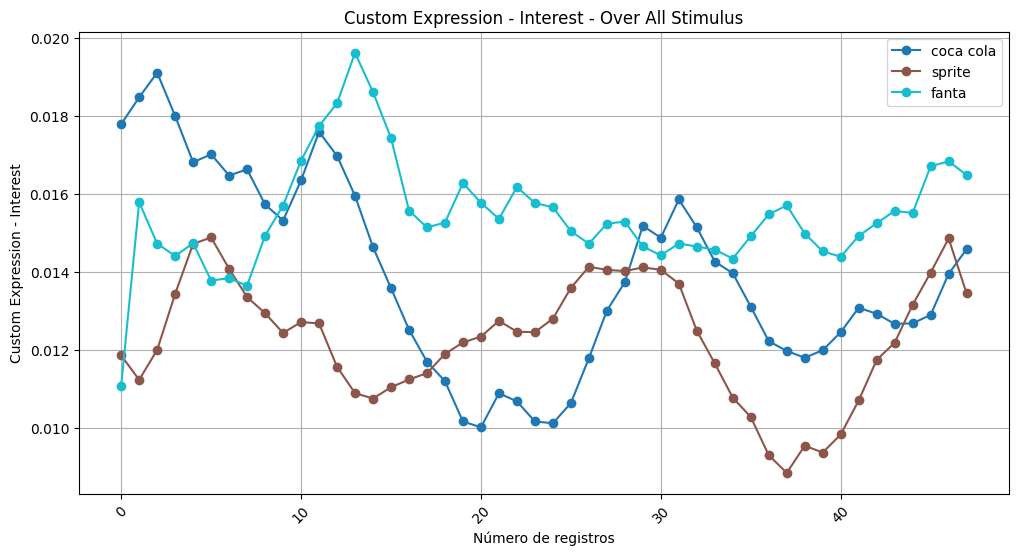

Promedios por estímulo:
coca cola (60 elementos): [np.float64(0.9644563666666666), np.float64(0.9717490736842107), np.float64(0.9766883543859648), np.float64(0.9763903157894736), np.float64(0.979797950877193), np.float64(0.9791544714285711), np.float64(0.9724478857142858), np.float64(0.9771737771929825), np.float64(0.9788489543859649), np.float64(0.9786183385964915), np.float64(0.9733303666666667), np.float64(0.9673486175438597), np.float64(0.9740432543859648), np.float64(0.9806430526315788), np.float64(0.982180454385965), np.float64(0.9844433052631578), np.float64(0.9824289228070174), np.float64(0.9801565087719298), np.float64(0.9824160596491226), np.float64(0.9831510526315791), np.float64(0.9833316789473685), np.float64(0.9832358263157894), np.float64(0.9740110403508772), np.float64(0.9789976456140351), np.float64(0.978443642105263), np.float64(0.975886392982456), np.float64(0.9749377649122806), np.float64(0.9732979421052632), np.float64(0.9746416473684212), np.float64(0.975992882456

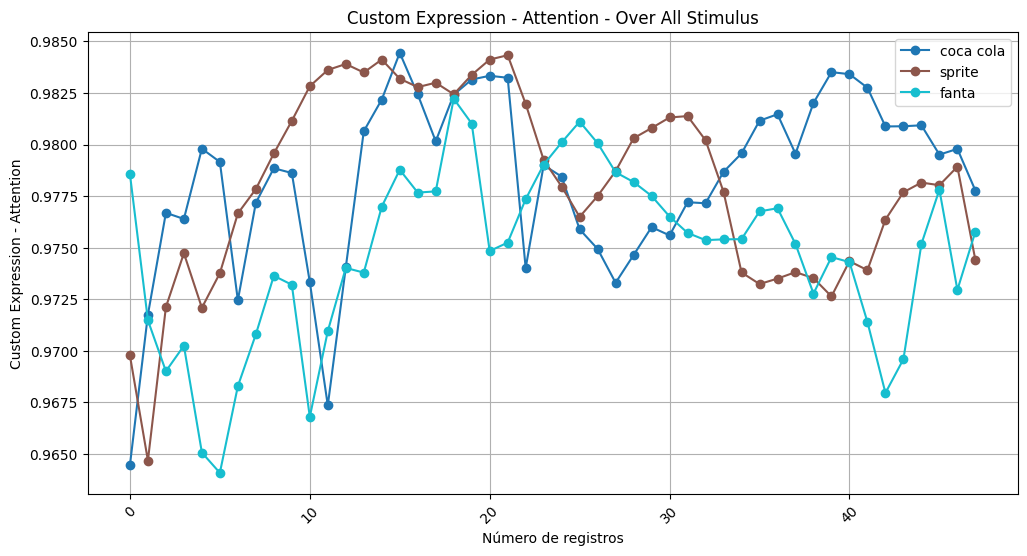

In [ ]:
for custom_exp in custom_expresion:
    averages_dict, min_length = extract_column_averages(df_filtered, list(specific_times_stimulus.values()), custom_exp, list(specific_times_stimulus.keys()))

    # Imprimir los resultados
    print("Promedios por estímulo:")
    for stimulus, avg_list in averages_dict.items():
        print(f"{stimulus} ({len(avg_list)} elementos): {avg_list}")

    print(f"El estímulo con menos elementos tiene {min_length} valores.")
    # Llamar a la función con el diccionario de promedios y los detalles del gráfico.
    plot_averages(averages_dict, f'{custom_exp} - Over All Stimulus', custom_exp)

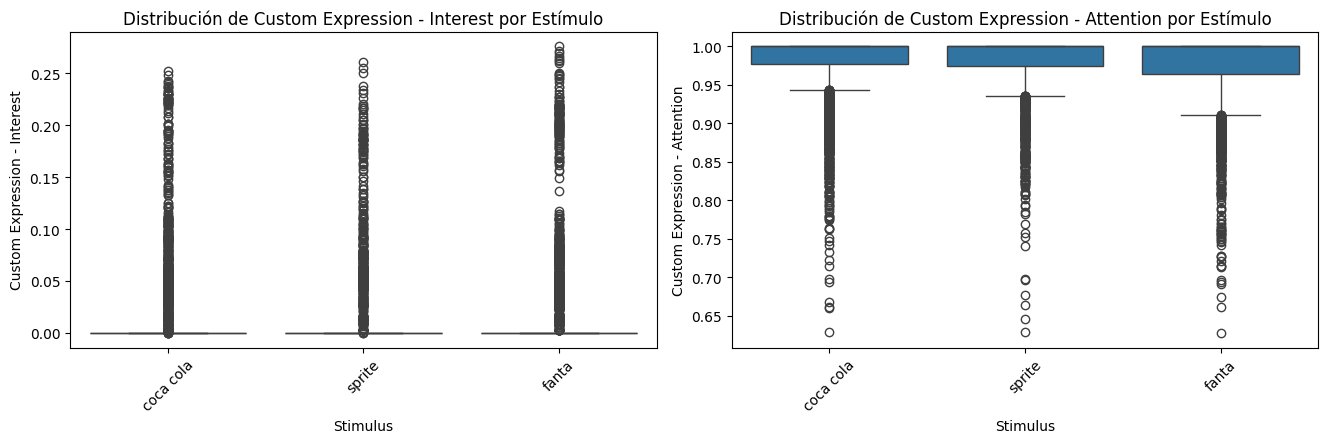

In [ ]:
# Crear una figura para los box plots
plt.figure(figsize=(20, 12))  # Ajustar tamaño de la figura

# Usar un bucle para crear un box plot para cada emoción
for i, ce in enumerate(custom_expresion):
    plt.subplot(3, 3, i + 1)  # Crear subplots, ajustando a 3 filas y 3 columnas
    sns.boxplot(x='Stimulus', y=ce, data=df_filtered)  # Graficar boxplot de cada emoción por estímulo
    plt.title(f'Distribución de {ce} por Estímulo')
    plt.xticks(rotation=45)  # Rotar etiquetas en el eje X para mejor visualización
    plt.tight_layout()  # Asegurar que no se sobrepongan los gráficos

# Mostrar todos los gráficos
plt.show()